# Pfizer Stock Price Prediction Project

## 1. Environment Setup

This project utilizes Python for data analysis and machine learning. The primary libraries used are:

*   **pandas:** For data manipulation and analysis, particularly for handling time series data in DataFrames.
*   **numpy:** For numerical computations, especially array operations.
*   **scikit-learn:** For machine learning tasks, including model building and evaluation.
*   **matplotlib & seaborn:** For data visualization, helping to understand trends and model performance.
*   **yfinance:** To download historical stock market data from Yahoo Finance.
*   **xgboost:** For the XGBoost classification model.
*   **jupyter:** As the interactive development environment for this project.

All analysis is conducted within a dedicated virtual environment (`pfizer_env`) to manage dependencies.

In [1]:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt # For plotting 
import seaborn as sns # For styling plots 

# Set plotting style
sns.set(style="darkgrid")


# 2. Data Extraction and Preprocessing

### 2.1. Data Source and Acquisition
Pfizer (PFE) stock data is downloaded using `yfinance` (Yahoo Finance). The period remains consistent with previous attempts: January 1, 2010 - April 16, 2025. 


In [2]:

ticker = "PFE" 
start_date = "2010-01-01" 
end_date = "2025-04-17" # Fetch one day extra to ensure data up to 2025-04-16 is included

print(f"Downloading {ticker} data from {start_date} to {end_date} (exclusive of end date)")
pf_data = yf.download(ticker, start=start_date, end=end_date)

# Select required columns
pf_data = pf_data[['Open', 'High', 'Low', 'Close', 'Volume']]
print("Data downloaded. First 5 rows:")
print(pf_data.head())
print("\nLast 5 rows:")
print(pf_data.tail())
print(f"\nShape of the data: {pf_data.shape}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data downloaded. First 5 rows:
Price           Open      High       Low     Close    Volume
Ticker           PFE       PFE       PFE       PFE       PFE
Date                                                        
2010-01-04  9.346312  9.689061  9.330966  9.683946  54898644
2010-01-05  9.678831  9.683947  9.489552  9.545824  45714931
2010-01-06  9.545822  9.622557  9.469088  9.515128  43640975
2010-01-07  9.535591  9.550938  9.443509  9.479319  41557112
2010-01-08  9.525360  9.571400  9.474203  9.556053  32049716

Last 5 rows:
Price            Open       High        Low      Close    Volume
Ticker            PFE        PFE        PFE        PFE       PFE
Date                                                            
2025-04-10  21.843291  21.853104  20.695193  21.185833  72960700
2025-04-11  21.185834  21.588159  20.881638  21.499844  55078100
2025-04-14  21.666660  21.813851  21.460592  21.705912  61900900
2025-04-15  21.754976  22.500749  21.715724  22.019922  51814700
2025-04-16  

### 2.2. Initial Data Cleaning & Preparation
A standard check for missing values (NaNs) is performed. The MultiIndex columns returned by `yfinance` are flattened to simplify column referencing.


In [3]:
import pandas as pd
import numpy as np 

print("\nChecking for missing values (NaNs):")
print(pf_data.isnull().sum())

# If there were missing values:
# pf_data.fillna(method='ffill', inplace=True)
# print("\nMissing values after forward-fill (if any were present):")
# print(pf_data.isnull().sum())

# Verify date range
print(f"\nData starts on: {pf_data.index.min()}")
print(f"Data ends on: {pf_data.index.max()}")


# convert to single level index:
if isinstance(pf_data.columns, pd.MultiIndex):
    print("Original pf_data columns (MultiIndex):", pf_data.columns.tolist())
    
    new_cols = {}
    # Iterate through the existing column tuples 
    for col_identifier in pf_data.columns:
        if isinstance(col_identifier, tuple):
            # col_identifier is a tuple
            top_level_name = col_identifier[0]
            second_level_name = col_identifier[1]

            if second_level_name == 'PFE':
                # If the second level is 'PFE', use the top-level name as the new column name.
                # This gives priority to 'PFE' columns if there's a name clash.
                new_cols[top_level_name] = pf_data[col_identifier]
            elif second_level_name == '' or second_level_name == '\\': # Handle common blank/placeholder second levels
                # If the second level is blank (e.g., for 'Baseline_PnL' from image)
                # and this top-level name hasn't been taken by a 'PFE' column
                if top_level_name not in new_cols:
                    new_cols[top_level_name] = pf_data[col_identifier]
                else:
                    # Handle name clash by suffixing the non-PFE column
                    print(f"Warning: Name clash for '{top_level_name}'. PFE version kept. Column ('{top_level_name}', '{second_level_name}') stored as '{top_level_name}_generic'.")
                    new_cols[f"{top_level_name}_generic"] = pf_data[col_identifier]
            # else: Other specific tickers (e.g., ('Close', 'MSFT')) would be ignored by this logic.
        else:
            # col_identifier is already a single string (already flat), keep it as is.
            if col_identifier not in new_cols: # Avoid overwriting if a PFE column was flattened to this name
                 new_cols[col_identifier] = pf_data[col_identifier]
            else:
                 print(f"Warning: Name clash for '{col_identifier}'. A PFE column was already flattened to this name. Original flat column '{col_identifier}' stored as '{col_identifier}_original_flat'.")
                 new_cols[f"{col_identifier}_original_flat"] = pf_data[col_identifier]
    
    pf_data = pd.DataFrame(new_cols)
    print("Flattened pf_data columns:", pf_data.columns.tolist())
else:
    print("pf_data columns are already single-level. No flattening applied.")


# Save the raw downloaded data
pf_data.to_csv("PFE_stock_data_2010_2025.csv")
print("\nRaw data saved to PFE_stock_data_2010_2025.csv")



Checking for missing values (NaNs):
Price   Ticker
Open    PFE       0
High    PFE       0
Low     PFE       0
Close   PFE       0
Volume  PFE       0
dtype: int64

Data starts on: 2010-01-04 00:00:00
Data ends on: 2025-04-16 00:00:00
Original pf_data columns (MultiIndex): [('Open', 'PFE'), ('High', 'PFE'), ('Low', 'PFE'), ('Close', 'PFE'), ('Volume', 'PFE')]
Flattened pf_data columns: ['Open', 'High', 'Low', 'Close', 'Volume']

Raw data saved to PFE_stock_data_2010_2025.csv


No missing values found.

### 2.3. Data Splitting (Raw Data)

*   **Training/Feature Engineering Base:** `2010-01-04` to Dec 31, 2021.
*   **Out-of-Sample (OOS) Base:** `2022-01-03` to Apr 16, 2025.


In [4]:
import pandas as pd

# Define split dates
train_end_date = "2021-12-31"
oos_start_date = "2022-01-01"

# Split the data
train_data = pf_data.loc[:train_end_date]
oos_data = pf_data.loc[oos_start_date:] # Goes to the end of pf_data, which is 2025-04-16

print("--- Data Splitting ---")
print(f"Full data range: {pf_data.index.min()} to {pf_data.index.max()}")
print(f"Training data: {train_data.index.min()} to {train_data.index.max()}, Shape: {train_data.shape}")
print(f"Out-of-Sample (OOS) data: {oos_data.index.min()} to {oos_data.index.max()}, Shape: {oos_data.shape}")

# Verify no overlap and full coverage 
if not train_data.empty and not oos_data.empty:
    assert train_data.index.max() < oos_data.index.min(), "Training and OOS data overlap or are not contiguous!"
    print("Data split verified: No overlap, correct periods.")
else:
    if train_data.empty:
        print("Warning: Training data is empty. Check split dates and data range.")
    if oos_data.empty:
        print("Warning: OOS data is empty. Check split dates and data range.")

# Store these 
train_data.to_csv("PFE_train_data.csv")
oos_data.to_csv("PFE_oos_data.csv")
print("\nTrain and OOS dataframes created.")



--- Data Splitting ---
Full data range: 2010-01-04 00:00:00 to 2025-04-16 00:00:00
Training data: 2010-01-04 00:00:00 to 2021-12-31 00:00:00, Shape: (3021, 5)
Out-of-Sample (OOS) data: 2022-01-03 00:00:00 to 2025-04-16 00:00:00, Shape: (825, 5)
Data split verified: No overlap, correct periods.

Train and OOS dataframes created.


## 2.4. Baseline Strategy: Buy and Hold
Methodology: Hold $1M of PFE stock long every trading day. PnL = `DailyReturn * $1M`.

**Performance (from output - Cell 5):**
*   **Entire Period (2010-01-04 - 2025-04-16):**
    *   Total Cumulative PnL: `$1,166,858.64`
*   **Out-of-Sample Period (2022-01-03 - 2025-04-16):**
    *   Total Cumulative PnL: `$-734,748.55`

--- Baseline Strategy: Buy and Hold (Entire Period) ---
               Close  DailyReturn  Baseline_PnL  Baseline_Cumulative_PnL
Date                                                                    
2010-01-04  9.683946          NaN           NaN                      NaN
2010-01-05  9.545824    -0.014263 -14262.947132            -14262.947132
2010-01-06  9.515128    -0.003216  -3215.638069            -17478.585202
2010-01-07  9.479319    -0.003763  -3763.429814            -21242.015015
2010-01-08  9.556053     0.008095   8094.942889            -13147.072126

Last 5 rows (Entire Period):
                Close  DailyReturn  Baseline_PnL  Baseline_Cumulative_PnL
Date                                                                     
2025-04-10  21.185833    -0.040018 -40017.790063             1.145811e+06
2025-04-11  21.499844     0.014822  14821.726408             1.160633e+06
2025-04-14  21.705912     0.009585   9584.629674             1.170217e+06
2025-04-15  22.019922     0.01446

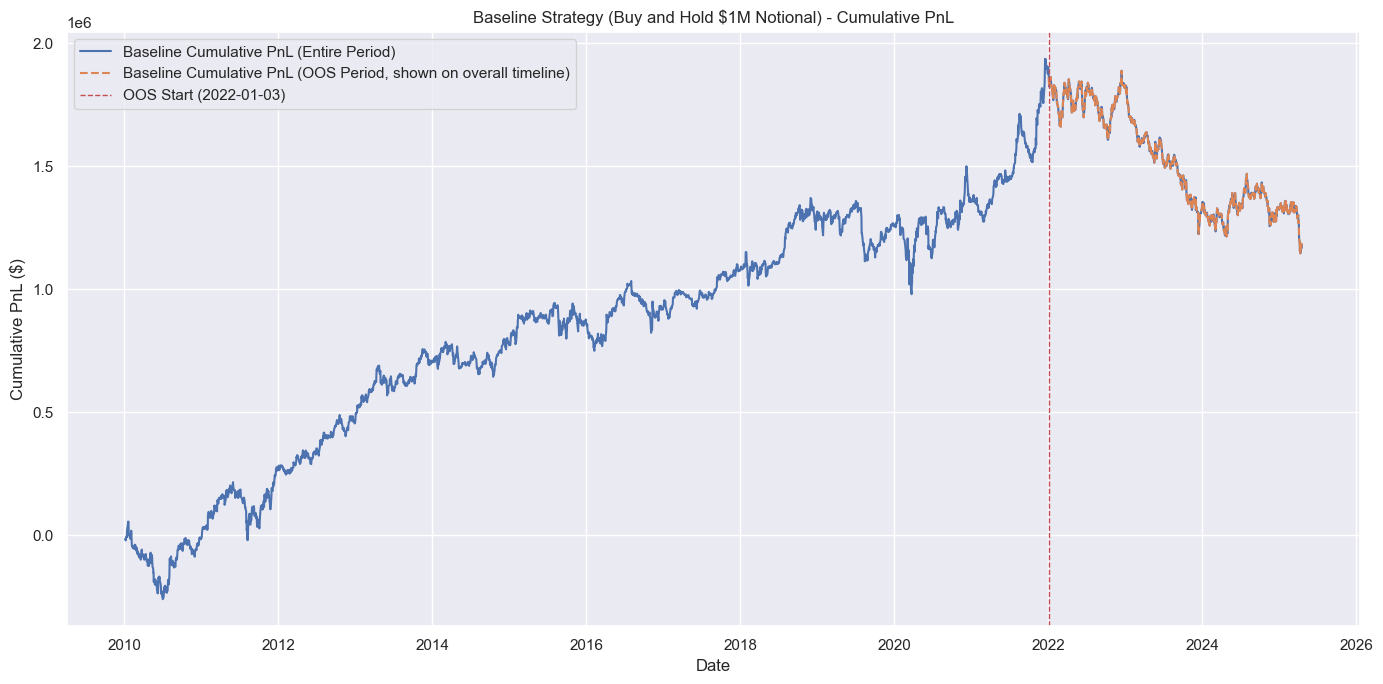

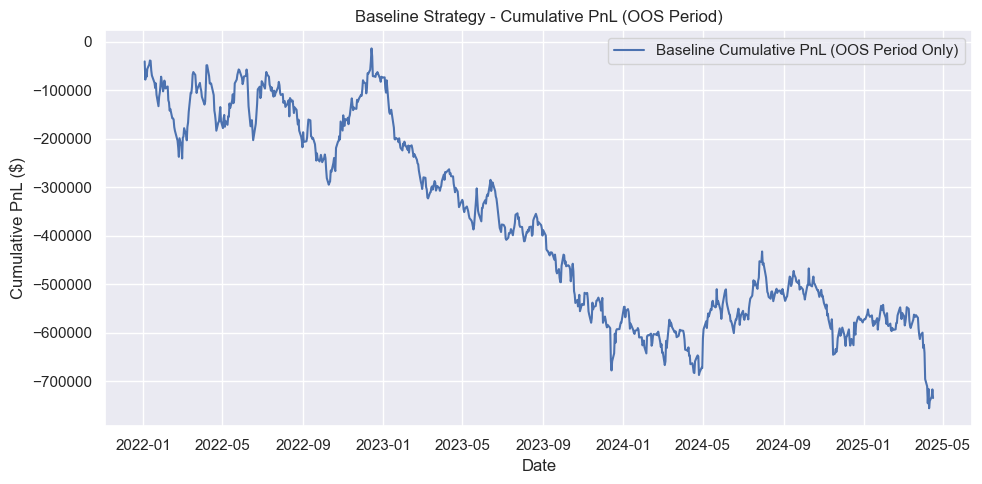


--- Key Performance Indicators for Baseline Strategy ---
Total PnL (Entire Period): $1,166,858.46
Total PnL (OOS Period): $-734,748.54


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style if not already set
sns.set(style="darkgrid")

# Calculate Daily Return
pf_data['DailyReturn'] = pf_data['Close'].pct_change()

# Calculate Baseline PnL
investment_amount = 1000000
pf_data['Baseline_PnL'] = pf_data['DailyReturn'] * investment_amount

# Calculate Baseline Cumulative PnL
pf_data['Baseline_Cumulative_PnL'] = pf_data['Baseline_PnL'].cumsum()

# --- Analyze Baseline PnL for the entire period ---
print("--- Baseline Strategy: Buy and Hold (Entire Period) ---")
print(pf_data[['Close', 'DailyReturn', 'Baseline_PnL', 'Baseline_Cumulative_PnL']].head())
print("\nLast 5 rows (Entire Period):")
print(pf_data[['Close', 'DailyReturn', 'Baseline_PnL', 'Baseline_Cumulative_PnL']].tail())

total_pnl_entire_period = pf_data['Baseline_Cumulative_PnL'].iloc[-1]
print(f"\nTotal PnL for Baseline (Entire Period): ${total_pnl_entire_period:,.2f}")

# --- Analyze Baseline PnL for the OOS period ---
oos_baseline_pnl_data = pf_data.loc[oos_data.index].copy() 
oos_baseline_pnl_data['Baseline_OOS_Cumulative_PnL'] = oos_baseline_pnl_data['Baseline_PnL'].cumsum()

print("\n--- Baseline Strategy: Buy and Hold (OOS Period Only) ---")
print(oos_baseline_pnl_data[['Close', 'DailyReturn', 'Baseline_PnL', 'Baseline_OOS_Cumulative_PnL']].head())
print("\nLast 5 rows (OOS Period):")
print(oos_baseline_pnl_data[['Close', 'DailyReturn', 'Baseline_PnL', 'Baseline_OOS_Cumulative_PnL']].tail())

total_pnl_oos_period = oos_baseline_pnl_data['Baseline_OOS_Cumulative_PnL'].iloc[-1]
print(f"\nTotal PnL for Baseline (OOS Period): ${total_pnl_oos_period:,.2f}")

# --- Visualization ---
plt.figure(figsize=(14, 7))

# Plot Cumulative PnL for the entire period
plt.plot(pf_data.index, pf_data['Baseline_Cumulative_PnL'], label='Baseline Cumulative PnL (Entire Period)')

# Highlight OOS period start for clarity on the same plot
oos_start_actual_date = oos_baseline_pnl_data.index.min()
oos_cumulative_pnl_at_start = pf_data.loc[pf_data.index < oos_start_actual_date, 'Baseline_Cumulative_PnL'].iloc[-1]

# Plot OOS period PnL, adjusted to show its own accumulation from the start of OOS
plt.plot(oos_baseline_pnl_data.index, oos_baseline_pnl_data['Baseline_OOS_Cumulative_PnL'] + oos_cumulative_pnl_at_start,
         label='Baseline Cumulative PnL (OOS Period, shown on overall timeline)', linestyle='--')


plt.title('Baseline Strategy (Buy and Hold $1M Notional) - Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL ($)')
plt.legend()
plt.axvline(oos_start_actual_date, color='r', linestyle='--', lw=1, label=f'OOS Start ({oos_start_actual_date.date()})')
plt.legend() # Call legend again to include axvline label
plt.tight_layout()
plt.show()

# Plot just OOS PnL starting from 0
plt.figure(figsize=(10, 5))
plt.plot(oos_baseline_pnl_data.index, oos_baseline_pnl_data['Baseline_OOS_Cumulative_PnL'], label='Baseline Cumulative PnL (OOS Period Only)')
plt.title('Baseline Strategy - Cumulative PnL (OOS Period)')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL ($)')
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Key Performance Indicators for Baseline Strategy ---")
print(f"Total PnL (Entire Period): ${total_pnl_entire_period:,.2f}")
print(f"Total PnL (OOS Period): ${total_pnl_oos_period:,.2f}")

# 3. Feature Engineering

Attempt 3 expands significantly on feature engineering, incorporating more exogenous factors and interaction terms, while maintaining the focus on log returns from Attempt 2.

## 3.1. Basic Technical Indicators
Builds on Attempt 2, prioritizing log returns.
*   **PFE Log Returns:** Daily, 5D, 10D, 21D.
*   **PFE Volatility of Log Returns:** 10D, 20D.
*   **SMAs (Close & Volume):** 10D, 20D, 50D, and Close/SMA20_Ratio.
*   **MACD, RSI, Bollinger Bands:** Standard parameters.
*   **Volume Indicators:** `Volume_Change_Pct`, `Volume_SMA_5_Ratio`.
*   **New in Attempt 3 - ATR (14D):** Added as a more comprehensive daily volatility measure.

*Rationale for ATR:* ATR incorporates High/Low prices, offering a better sense of true range and market choppiness compared to close-price-only volatility.

In [6]:
import numpy as np
import pandas as pd 

data = pf_data.copy()

# --- Log Returns (Primary Return Measure for Features) ---
print("\nCalculating Log Returns for PFE...")
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
for n in [5, 10, 21]: # 21 days is approx 1 trading month
    data[f'LogReturn_{n}D'] = data['LogReturn'].rolling(window=n).sum()

# DailyReturn for PnL calculations and original baseline
data['DailyReturn'] = data['Close'].pct_change() 
if 'Baseline_PnL' not in data.columns: 
    investment_amount = 1000000
    data['Baseline_PnL'] = data['DailyReturn'] * investment_amount
    data['Baseline_Cumulative_PnL'] = data['Baseline_PnL'].cumsum()


# --- Moving Averages (SMA) - Based on Close Price and Volume ---
print("Calculating Moving Averages...")
for n in [10, 20, 50]:
    data[f'SMA_{n}_Close'] = data['Close'].rolling(window=n).mean()
    data[f'SMA_{n}_Volume'] = data['Volume'].rolling(window=n).mean()
data['Close_SMA_20_Ratio'] = data['Close'] / data['SMA_20_Close']

# --- Moving Average Convergence Divergence (MACD) - Based on Close Price ---
print("Calculating MACD...")
ema_short_period = 12
ema_long_period = 26
signal_period = 9
data['EMA_Short_Close'] = data['Close'].ewm(span=ema_short_period, adjust=False).mean()
data['EMA_Long_Close'] = data['Close'].ewm(span=ema_long_period, adjust=False).mean()
data['MACD'] = data['EMA_Short_Close'] - data['EMA_Long_Close']
data['MACD_Signal'] = data['MACD'].ewm(span=signal_period, adjust=False).mean()
data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']

# --- Relative Strength Index (RSI) - Based on Close Price changes ---
print("Calculating RSI...")
rsi_period = 14
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# --- Bollinger Bands - Based on Close Price ---
print("Calculating Bollinger Bands...")
bb_period = 20
bb_std_dev_multiplier = 2
data[f'SMA_{bb_period}_Close_BB'] = data['Close'].rolling(window=bb_period).mean()
data['StdDev_Close_BB'] = data['Close'].rolling(window=bb_period).std()
data['Bollinger_Upper'] = data[f'SMA_{bb_period}_Close_BB'] + (data['StdDev_Close_BB'] * bb_std_dev_multiplier)
data['Bollinger_Lower'] = data[f'SMA_{bb_period}_Close_BB'] - (data['StdDev_Close_BB'] * bb_std_dev_multiplier)
data['Bollinger_Bandwidth'] = (data['Bollinger_Upper'] - data['Bollinger_Lower']) / data[f'SMA_{bb_period}_Close_BB']
data['Price_Bollinger_Pct'] = (data['Close'] - data['Bollinger_Lower']) / (data['Bollinger_Upper'] - data['Bollinger_Lower'])

# --- Volatility (Rolling Std Dev of Daily Log Returns) ---
print("Calculating Volatility (Rolling Std Dev of Daily Log Returns)...")
for n in [10, 20]:
    data[f'Volatility_{n}D_Log'] = data['LogReturn'].rolling(window=n).std() * np.sqrt(n) # Annualized for comparison if needed

# --- Volume Indicators ---
print("Calculating Volume Indicators...")
data['Volume_Change_Pct'] = data['Volume'].pct_change() # Renamed from 'Volume_Change' for clarity
data['Volume_SMA_5_Ratio'] = data['Volume'] / data['Volume'].rolling(window=5).mean()

# --- Average True Range (ATR) - Volatility based on High, Low, Close ---
print("Calculating ATR...")
atr_period = 14
high_low = data['High'] - data['Low']
high_close_prev = np.abs(data['High'] - data['Close'].shift(1))
low_close_prev = np.abs(data['Low'] - data['Close'].shift(1))
true_range_df = pd.concat([high_low, high_close_prev, low_close_prev], axis=1)
true_range = true_range_df.max(axis=1)
data['ATR_14'] = true_range.rolling(window=atr_period).mean() # Using SMA for ATR here


print("\nBasic technical indicators calculated (prioritizing log returns where appropriate).")
print("Data shape after basic features:", data.shape)
print("\nNaNs created by rolling features at the beginning (showing counts for columns with any NaNs):")
nan_counts_basic = data.isnull().sum()
print(nan_counts_basic[nan_counts_basic > 0])
print("\nTail of data with basic features:")
display_cols_basic = ['Close', 'LogReturn', 'SMA_20_Close', 'MACD_Hist', 'RSI', 'Price_Bollinger_Pct', 'Volatility_20D_Log', 'Volume_SMA_5_Ratio', 'ATR_14']
print(data[display_cols_basic].tail())


Calculating Log Returns for PFE...
Calculating Moving Averages...
Calculating MACD...
Calculating RSI...
Calculating Bollinger Bands...
Calculating Volatility (Rolling Std Dev of Daily Log Returns)...
Calculating Volume Indicators...
Calculating ATR...

Basic technical indicators calculated (prioritizing log returns where appropriate).
Data shape after basic features: (3846, 36)

NaNs created by rolling features at the beginning (showing counts for columns with any NaNs):
DailyReturn                 1
Baseline_PnL                1
Baseline_Cumulative_PnL     1
LogReturn                   1
LogReturn_5D                5
LogReturn_10D              10
LogReturn_21D              21
SMA_10_Close                9
SMA_10_Volume               9
SMA_20_Close               19
SMA_20_Volume              19
SMA_50_Close               49
SMA_50_Volume              49
Close_SMA_20_Ratio         19
RSI                        13
SMA_20_Close_BB            19
StdDev_Close_BB            19
Bollinger_Up

## 3.2. Creative & Exogenous Features

This attempt introduces several new exogenous and derived features to capture broader market and economic context. Log returns are used for exogenous asset price changes.

*   **VIX (^VIX - Original & New):**
    *   Kept: `VIX_Close`, `VIX_LogReturn`.
    *   New: `VIX_MA_10_Ratio`, `VIX_ROC_5`.
    *   *Rationale:* Gauge market fear and its recent trend/momentum.
*   **S&P 500 (^GSPC - Original & New):**
    *   Kept: `GSPC_Close`, `GSPC_LogReturn`, relative log returns.
    *   New: `Rolling_Correlation_PFE_GSPC_21D`, `Rolling_Beta_PFE_GSPC_63D`.
    *   *Rationale:* PFE vs. market; new features capture dynamic relationship.
*   **New in Attempt 3 - Other Exogenous Factors:**
    *   **10-Yr Treasury Yield (^TNX):** `TNX_Close`, `TNX_LogReturn`, `TNX_MA_10_Ratio`. *Rationale: Interest rate proxy.*
    *   **USD Index (DX-Y.NYB):** `USD_Index_Close`, `USD_Index_LogReturn`. *Rationale: Currency impact on multinational PFE.*
    *   **Pharma ETF (XPH):** `XPH_Close`, `XPH_LogReturn`, relative log returns vs. PFE. *Rationale: Sector benchmark.*
    *   **Crude Oil (CL=F):** `Oil_Close`, `Oil_LogReturn`. *Rationale: Economic activity/inflation proxy.*
*   **New in Attempt 3 - Interaction & Time Features:**
    *   `LogReturn_x_Volume_SMA_5_Ratio`
    *   `Volatility_10D_Log_x_VIX_Close`
    *   `DayOfWeek_Cat`, `Month_Cat` (to be OHE).
    *   *Rationale:* Capture combined effects and potential seasonality.


In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import OneHotEncoder 


print("\n--- Calculating Creative & Exogenous Features ---")

start_date_download = data.index.min()
end_date_download = data.index.max() + pd.Timedelta(days=3) # Add a bit more buffer for end date

# Helper function for downloading and processing exogenous data (log returns prioritized)
def download_and_process_exog(ticker_symbol, column_prefix, data_df):
    print(f"Downloading {ticker_symbol} data...")
    try:
        exog_download = yf.download(ticker_symbol, start=start_date_download, end=end_date_download, progress=False)
        if exog_download.empty:
            raise ValueError(f"{ticker_symbol} data download was empty.")
            
        price_col_to_use = 'Close'
        
        close_series = None
        if isinstance(exog_download.columns, pd.MultiIndex):
            if (price_col_to_use, ticker_symbol) in exog_download.columns: close_series = exog_download[(price_col_to_use, ticker_symbol)]
            elif price_col_to_use in exog_download and isinstance(exog_download[price_col_to_use], pd.DataFrame) and ticker_symbol in exog_download[price_col_to_use].columns: close_series = exog_download[price_col_to_use][ticker_symbol]
            elif price_col_to_use in exog_download and isinstance(exog_download[price_col_to_use], pd.DataFrame) and len(exog_download[price_col_to_use].columns) == 1: close_series = exog_download[price_col_to_use].iloc[:, 0]
            elif price_col_to_use in exog_download.columns and not isinstance(exog_download.columns, pd.MultiIndex): close_series = exog_download[price_col_to_use]
            else: # Fallback to simple 'Close' if specific structure isn't found
                price_col_to_use = 'Close'
                if ('Close', ticker_symbol) in exog_download.columns: close_series = exog_download[('Close', ticker_symbol)]
                elif 'Close' in exog_download and isinstance(exog_download['Close'], pd.DataFrame) and ticker_symbol in exog_download['Close'].columns: close_series = exog_download['Close'][ticker_symbol]
                elif 'Close' in exog_download and isinstance(exog_download['Close'], pd.DataFrame) and len(exog_download['Close'].columns) == 1: close_series = exog_download['Close'].iloc[:, 0]
                elif 'Close' in exog_download.columns and not isinstance(exog_download.columns, pd.MultiIndex): close_series = exog_download['Close']
                else: raise ValueError(f"Could not extract Close/Adj Close series for {ticker_symbol} from {exog_download.columns}")
        else: # Simple column index
            if price_col_to_use in exog_download.columns: close_series = exog_download[price_col_to_use]
            elif 'Close' in exog_download.columns: close_series = exog_download['Close'] # Fallback
            else: raise ValueError(f"Could not find {price_col_to_use} or 'Close' column in {ticker_symbol} data.")

        if close_series is not None:
            exog_df_to_join = close_series.to_frame(name=f'{column_prefix}_Close')
            data_df = data_df.join(exog_df_to_join, how='left')
            data_df[f'{column_prefix}_Close'] = data_df[f'{column_prefix}_Close'].ffill().bfill()
            data_df[f'{column_prefix}_LogReturn'] = np.log(data_df[f'{column_prefix}_Close'] / data_df[f'{column_prefix}_Close'].shift(1))
            print(f"{ticker_symbol} data integrated.")
        else:
            raise ValueError(f"{column_prefix}_Close series could not be extracted.")
            
    except Exception as e:
        print(f"Error processing {ticker_symbol} data: {e}. Using placeholder NaNs for {column_prefix} features.")
        data_df[f'{column_prefix}_Close'] = np.nan
        data_df[f'{column_prefix}_LogReturn'] = np.nan
    return data_df

# --- 3.2.1. VIX Data (Original + New) ---
data = download_and_process_exog("^VIX", "VIX", data)
if 'VIX_Close' in data.columns:
    data['VIX_SMA_10'] = data['VIX_Close'].rolling(window=10).mean() # Temp for ratio
    data['VIX_MA_10_Ratio'] = data['VIX_Close'] / data['VIX_SMA_10']
    data['VIX_ROC_5'] = data['VIX_Close'].pct_change(periods=5) * 100
    data.drop(columns=['VIX_SMA_10'], inplace=True, errors='ignore')
else:
    data['VIX_MA_10_Ratio'] = np.nan
    data['VIX_ROC_5'] = np.nan


# --- 3.2.2. S&P 500 (^GSPC) Data (Original + New) ---
data = download_and_process_exog("^GSPC", "GSPC", data)
if 'LogReturn' in data.columns and 'GSPC_LogReturn' in data.columns:
    data['Relative_LogReturn_GSPC'] = data['LogReturn'] - data['GSPC_LogReturn']
    data['GSPC_LogReturn_5D'] = data['GSPC_LogReturn'].rolling(window=5).sum()
    if 'LogReturn_5D' in data.columns:
         data['PFE_LogReturn_5D_vs_GSPC_LogReturn_5D'] = data['LogReturn_5D'] - data['GSPC_LogReturn_5D']

    if data['LogReturn'].notna().sum() > 21 and data['GSPC_LogReturn'].notna().sum() > 21:
         data['Rolling_Correlation_PFE_GSPC_21D'] = data['LogReturn'].rolling(window=21).corr(data['GSPC_LogReturn'])
    else: data['Rolling_Correlation_PFE_GSPC_21D'] = np.nan
    
    if data['LogReturn'].notna().sum() > 63 and data['GSPC_LogReturn'].notna().sum() > 63:
        rolling_window_beta = 63
        rolling_cov = data['LogReturn'].rolling(window=rolling_window_beta).cov(data['GSPC_LogReturn'])
        rolling_var_gspc = data['GSPC_LogReturn'].rolling(window=rolling_window_beta).var()
        data['Rolling_Beta_PFE_GSPC_63D'] = rolling_cov / rolling_var_gspc
    else: data['Rolling_Beta_PFE_GSPC_63D'] = np.nan
else:
    print("Warning: PFE LogReturn or GSPC LogReturn not found for all S&P500 relative calculations.")
    data['Relative_LogReturn_GSPC'] = np.nan
    data['PFE_LogReturn_5D_vs_GSPC_LogReturn_5D'] = np.nan
    data['Rolling_Correlation_PFE_GSPC_21D'] = np.nan
    data['Rolling_Beta_PFE_GSPC_63D'] = np.nan


# --- 3.2.3. US 10-Year Treasury Yield (^TNX) ---
data = download_and_process_exog("^TNX", "TNX", data)
if 'TNX_Close' in data.columns:
    data['TNX_SMA_10'] = data['TNX_Close'].rolling(window=10).mean() # Temp for ratio
    data['TNX_MA_10_Ratio'] = data['TNX_Close'] / data['TNX_SMA_10']
    data.drop(columns=['TNX_SMA_10'], inplace=True, errors='ignore')
else: data['TNX_MA_10_Ratio'] = np.nan

# --- 3.2.4. USD Index (DX-Y.NYB) ---
data = download_and_process_exog("DX-Y.NYB", "USD_Index", data)

# --- 3.2.5. Pharmaceutical Sector ETF (XPH) ---
data = download_and_process_exog("XPH", "XPH", data)
if 'LogReturn' in data.columns and 'XPH_LogReturn' in data.columns:
    data['Relative_LogReturn_XPH'] = data['LogReturn'] - data['XPH_LogReturn']
    data['XPH_LogReturn_5D'] = data['XPH_LogReturn'].rolling(window=5).sum()
    if 'LogReturn_5D' in data.columns:
        data['PFE_LogReturn_5D_vs_XPH_LogReturn_5D'] = data['LogReturn_5D'] - data['XPH_LogReturn_5D']
else:
    print("Warning: PFE LogReturn or XPH LogReturn not found for all XPH relative calculations.")
    data['Relative_LogReturn_XPH'] = np.nan
    data['PFE_LogReturn_5D_vs_XPH_LogReturn_5D'] = np.nan


# --- 3.2.6. Crude Oil Prices (CL=F) ---
data = download_and_process_exog("CL=F", "Oil", data)

# --- 3.2.7. Interaction & Advanced Features ---
if 'LogReturn' in data.columns and 'Volume_SMA_5_Ratio' in data.columns:
    data['LogReturn_x_Volume_SMA_5_Ratio'] = data['LogReturn'] * data['Volume_SMA_5_Ratio']
else: data['LogReturn_x_Volume_SMA_5_Ratio'] = np.nan

if 'Volatility_10D_Log' in data.columns and 'VIX_Close' in data.columns:
    data['Volatility_10D_Log_x_VIX_Close'] = data['Volatility_10D_Log'] * data['VIX_Close']
else: data['Volatility_10D_Log_x_VIX_Close'] = np.nan

# --- Day of Week & Month Features (Categorical - OHE will be done after NaN drop) ---
data['DayOfWeek_Cat'] = data.index.dayofweek 
data['Month_Cat'] = data.index.month

print("\nCreative and Exogenous features calculation complete (OHE for date parts will be done after NaN handling).")
print("Data shape after adding new columns:", data.shape)

# Display tails of some new features
cols_to_show_creative = [
    'VIX_Close', 'VIX_LogReturn', 'VIX_MA_10_Ratio', 'VIX_ROC_5',
    'GSPC_Close', 'GSPC_LogReturn', 'Relative_LogReturn_GSPC', 
    'Rolling_Correlation_PFE_GSPC_21D', 'Rolling_Beta_PFE_GSPC_63D',
    'TNX_Close', 'TNX_LogReturn', 'TNX_MA_10_Ratio',
    'USD_Index_Close', 'USD_Index_LogReturn',
    'XPH_Close', 'XPH_LogReturn', 'Relative_LogReturn_XPH',
    'Oil_Close', 'Oil_LogReturn',
    'LogReturn_x_Volume_SMA_5_Ratio', 'Volatility_10D_Log_x_VIX_Close',
    'DayOfWeek_Cat', 'Month_Cat'
]
existing_cols_to_show_creative = [col for col in cols_to_show_creative if col in data.columns]
if existing_cols_to_show_creative:
    print(data[existing_cols_to_show_creative].tail())
else:
    print("No new exogenous columns to show in tail due to errors or them not being created.")


--- Calculating Creative & Exogenous Features ---
^VIX data integrated.
^GSPC data integrated.
^TNX data integrated.
DX-Y.NYB data integrated.
XPH data integrated.
CL=F data integrated.

Creative and Exogenous features calculation complete (OHE for date parts will be done after NaN handling).
Data shape after adding new columns: (3846, 63)
            VIX_Close  VIX_LogReturn  VIX_MA_10_Ratio  VIX_ROC_5   GSPC_Close  \
Date                                                                            
2025-04-10  40.720001       0.191598         1.211220  35.642907  5268.049805   
2025-04-11  37.560001      -0.080780         1.066742 -17.104391  5363.359863   
2025-04-14  30.889999      -0.195507         0.856367 -34.248617  5405.970215   
2025-04-15  30.120001      -0.025243         0.816127 -42.442194  5396.629883   
2025-04-16  32.639999       0.080349         0.858518  -2.914930  5275.700195   

            GSPC_LogReturn  Relative_LogReturn_GSPC  \
Date                              

C:\Users\devan\Desktop\Pfizer\pfizer_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 3.3. One-Hot Encoding & Final NaN Handling

### 3.3.1. One-Hot Encoding
`DayOfWeek_Cat` and `Month_Cat` are one-hot encoded to create binary features for each category.

### 3.3.2. Handling NaNs
*   **Initial Fill:** Exogenous data `_Close`, `_LogReturn`, ratios, ROCs, correlations, betas, ATR, and Volume_Change_Pct are ffilled then bfilled to handle NaNs from joins/initial calculations.
*   **Final Drop:** All remaining rows with NaNs (from rolling features like SMAs, Bollinger Bands, RSI) are dropped.
*   **Impact:** Effective start date shifts to `[2010-03-16]`.

In [8]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

print("\n--- Final Feature Processing & Handling NaNs ---")

# --- One-Hot Encode DayOfWeek and Month ---
if 'DayOfWeek_Cat' in data.columns and 'Month_Cat' in data.columns:
    print("One-Hot Encoding DayOfWeek_Cat and Month_Cat...")
    data = pd.get_dummies(data, columns=['DayOfWeek_Cat'], prefix='DayOfWeek', drop_first=False) # Keep all days
    data = pd.get_dummies(data, columns=['Month_Cat'], prefix='Month', drop_first=False)       # Keep all months
    print("One-Hot Encoding complete.")
else:
    print("DayOfWeek_Cat or Month_Cat column not found. Skipping OHE.")


# --- Handling NaNs ---
# Identify columns that might have NaNs due to shifts, pct_change, or initial missing data in joined series
cols_potentially_needing_fill = [
    'LogReturn', 'LogReturn_5D', 'LogReturn_10D', 'LogReturn_21D',
    'VIX_LogReturn', 'VIX_MA_10_Ratio', 'VIX_ROC_5',
    'GSPC_LogReturn', 'Relative_LogReturn_GSPC', 'PFE_LogReturn_5D_vs_GSPC_LogReturn_5D',
    'Rolling_Correlation_PFE_GSPC_21D', 'Rolling_Beta_PFE_GSPC_63D',
    'TNX_LogReturn', 'TNX_MA_10_Ratio',
    'USD_Index_LogReturn',
    'XPH_LogReturn', 'Relative_LogReturn_XPH', 'PFE_LogReturn_5D_vs_XPH_LogReturn_5D',
    'Oil_LogReturn',
    'Volume_Change_Pct',
    'ATR_14'
]
# Also add the _Close columns for exogenous data as they might have leading/trailing NaNs after join
exog_close_cols = [col for col in data.columns if '_Close' in col and col not in ['Open','High','Low','Close']] # PFE's own close handled differently
cols_potentially_needing_fill.extend(exog_close_cols)

# Apply ffill then bfill to handle NaNs from joins and initial calculations
for col in cols_potentially_needing_fill:
    if col in data.columns:
        data[col] = data[col].ffill() # Forward fill first
        data[col] = data[col].bfill() # Then backfill to catch any at the very beginning

# Drop rows with any remaining NaNs (mostly from initial rolling windows of SMAs, Bollinger, RSI etc.)
initial_rows = len(data)
data.dropna(inplace=True)
final_rows = len(data)
print(f"\nDropped {initial_rows - final_rows} total rows due to NaNs from all feature calculations.")
print(f"Shape of data after NaN removal: {data.shape}")

if not data.empty:
    print(f"Data now spans from {data.index.min()} to {data.index.max()}")
else:
    print("Warning: DataFrame is empty after dropping NaNs. Check window sizes and data length.")

print("\nFinal check for any remaining NaNs:")
print(data.isnull().sum().sum())

print("\nSample of data with all features (after OHE and NaN drop):")
print(data.head())



--- Final Feature Processing & Handling NaNs ---
One-Hot Encoding DayOfWeek_Cat and Month_Cat...
One-Hot Encoding complete.

Dropped 49 total rows due to NaNs from all feature calculations.
Shape of data after NaN removal: (3797, 78)
Data now spans from 2010-03-16 00:00:00 to 2025-04-16 00:00:00

Final check for any remaining NaNs:
0

Sample of data with all features (after OHE and NaN drop):
                Open      High       Low     Close     Volume  DailyReturn  \
Date                                                                         
2010-03-16  8.943998  8.974982  8.835554  8.913013   56037175     0.000000   
2010-03-17  8.913018  8.938837  8.861378  8.887198   59708468    -0.002896   
2010-03-18  8.954328  8.959492  8.840720  8.897524   53653975     0.001162   
2010-03-19  8.732279  8.933673  8.675475  8.732279  119353801    -0.018572   
2010-03-22  8.778753  8.907853  8.768426  8.856213   74916107     0.014193   

            Baseline_PnL  Baseline_Cumulative_PnL  LogRe

## 3.4. Refining Features with Logarithmic Returns

To improve the stationarity of some price-based features and potentially capture multiplicative effects more appropriately, we will calculate or re-calculate certain features using logarithmic returns. Log returns are often preferred in financial time series analysis for these properties.

**Features to be refined/added:**
*   **Daily Log Return (`LogReturn`):** `ln(Close_t / Close_t-1)` for PFE.
*   **N-Day Log Returns (`LogReturn_ND` for 5D, 10D, 21D):** Sum of daily log returns over N days for PFE.
*   **Volatility of Log Returns (`Volatility_ND_Log` for 10D, 20D):** Rolling standard deviation of PFE's daily log returns.
*   **VIX Log Return (`VIX_LogReturn`):** Daily log return of `VIX_Close`.
*   **GSPC Log Return (`GSPC_LogReturn`):** Daily log return of `GSPC_Close`.
*   **Relative Log Return vs. GSPC (`Relative_LogReturn_GSPC`):** `LogReturn (PFE) - GSPC_LogReturn`.
*   **PFE 5D Log Return vs. GSPC 5D Log Return (`PFE_LogReturn_5D_vs_GSPC_LogReturn_5D`)**.

Other features like SMAs, EMAs (for MACD), and Bollinger Bands will continue to be based on the 'Close' price. RSI will also remain as originally calculated. Volume-based features are unaffected. Simple daily returns (`DailyReturn` from cell 22) will be kept in the `data` DataFrame as it's used for PnL calculation and was used for the original `Baseline_PnL`.


In [9]:
import numpy as np
import pandas as pd

print("--- Refining Features with Log Returns ---")

# 1. Daily Log Return for PFE
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))

# 2. N-Day Log Returns for PFE
for n in [5, 10, 21]:
    data[f'LogReturn_{n}D'] = data['LogReturn'].rolling(window=n).sum()

# 3. Volatility of Log Returns for PFE
# Original Volatility_ND were based on simple returns. These are new log-based versions.
for n in [10, 20]:
    data[f'Volatility_{n}D_Log'] = data['LogReturn'].rolling(window=n).std() * np.sqrt(n) 

# 4. VIX Log Return
if 'VIX_Close' in data.columns:
    data['VIX_LogReturn'] = np.log(data['VIX_Close'] / data['VIX_Close'].shift(1))
else:
    print("Warning: VIX_Close not found. VIX_LogReturn will be NaN.")
    data['VIX_LogReturn'] = np.nan

# 5. GSPC Log Return
if 'GSPC_Close' in data.columns:
    data['GSPC_LogReturn'] = np.log(data['GSPC_Close'] / data['GSPC_Close'].shift(1))
else:
    print("Warning: GSPC_Close not found. GSPC_LogReturn will be NaN.")
    data['GSPC_LogReturn'] = np.nan

# 6. Relative Log Return vs. GSPC
if 'LogReturn' in data.columns and 'GSPC_LogReturn' in data.columns:
    data['Relative_LogReturn_GSPC'] = data['LogReturn'] - data['GSPC_LogReturn']
else:
    print("Warning: LogReturn or GSPC_LogReturn not found. Relative_LogReturn_GSPC will be NaN.")
    data['Relative_LogReturn_GSPC'] = np.nan
    
# 7. PFE 5D Log Return vs. GSPC 5D Log Return
# First, calculate 5D Log Return for GSPC
if 'GSPC_LogReturn' in data.columns:
    data['GSPC_LogReturn_5D'] = data['GSPC_LogReturn'].rolling(window=5).sum()
    if 'LogReturn_5D' in data.columns:
        data['PFE_LogReturn_5D_vs_GSPC_LogReturn_5D'] = data['LogReturn_5D'] - data['GSPC_LogReturn_5D']
    else:
        print("Warning: LogReturn_5D for PFE not found. PFE_LogReturn_5D_vs_GSPC_LogReturn_5D will be NaN.")
        data['PFE_LogReturn_5D_vs_GSPC_LogReturn_5D'] = np.nan
else:
    print("Warning: GSPC_LogReturn not found. GSPC_LogReturn_5D and PFE_LogReturn_5D_vs_GSPC_LogReturn_5D will be NaN.")
    data['GSPC_LogReturn_5D'] = np.nan
    data['PFE_LogReturn_5D_vs_GSPC_LogReturn_5D'] = np.nan


# Display some of the new/refined features
print("\nSample of data with new log-return based features (tail):")
print(data[['Close', 'LogReturn', 'LogReturn_5D', 'Volatility_10D_Log', 
            'VIX_Close', 'VIX_LogReturn', 'GSPC_Close', 'GSPC_LogReturn', 
            'Relative_LogReturn_GSPC', 'PFE_LogReturn_5D_vs_GSPC_LogReturn_5D']].tail())

print("\nShape of data after adding log features:", data.shape)
print("NaNs created by new log features at the beginning (first 25 rows):")
print(data.head(25).isnull().sum())

--- Refining Features with Log Returns ---

Sample of data with new log-return based features (tail):
                Close  LogReturn  LogReturn_5D  Volatility_10D_Log  VIX_Close  \
Date                                                                            
2025-04-10  21.185833  -0.040841     -0.117835            0.084422  40.720001   
2025-04-11  21.499844   0.014713     -0.047246            0.086675  37.560001   
2025-04-14  21.705912   0.009539     -0.022794            0.087858  30.889999   
2025-04-15  22.019922   0.014363      0.027102            0.089263  30.120001   
2025-04-16  21.627411  -0.017986     -0.020212            0.087903  32.639999   

            VIX_LogReturn   GSPC_Close  GSPC_LogReturn  \
Date                                                     
2025-04-10       0.191598  5268.049805       -0.035221   
2025-04-11      -0.080780  5363.359863        0.017930   
2025-04-14      -0.195507  5405.970215        0.007913   
2025-04-15      -0.025243  5396.629883  

# 4. Modeling

## 4.1. Define Target Variable
*   **`NextDayReturn`:** `(Close_{t+1} - Close_t) / Close_t` (Simple return for target).
*   **`Target` (y):** `1` if `NextDayReturn > 0`, `0` otherwise.
*   **`Target_Lag1` (Feature):** `Target_{t-1}`.

*Rationale:* Consistent target definition. Final NaNs (from target creation & lag) are dropped. Effective data spans `[2010-04-15]` to `[2025-04-15]`.

In [10]:
print("--- Defining Target Variable ---")

# Calculate Next Day's *Simple* Return for the target definition
data['NextDayReturn'] = data['DailyReturn'].shift(-1) # Shift simple daily return

# Create binary target variable
data['Target'] = (data['NextDayReturn'] > 0).astype(int)

# Create Lagged Target as a feature
data['Target_Lag1'] = data['Target'].shift(1)

print("Target variable and Target_Lag1 created.")
print(data[['Close', 'DailyReturn', 'NextDayReturn', 'Target', 'Target_Lag1']].head()) 
print(data[['Close', 'DailyReturn','NextDayReturn', 'Target', 'Target_Lag1']].tail())

# Handle NaNs globally *again* after target creation (due to shift(-1) for NextDayReturn and shift(1) for Target_Lag1)
print("\n--- Final NaN Handling after Target Creation ---")
initial_rows_before_final_dropna = len(data)
data.dropna(inplace=True) # This will drop the last row (no NextDayReturn) and first row (no Target_Lag1)
final_rows_after_final_dropna = len(data)

print(f"Dropped {initial_rows_before_final_dropna - final_rows_after_final_dropna} additional rows due to target creation.")
print(f"Shape of data after final NaN removal: {data.shape}")
if not data.empty:
    print(f"Data now spans from {data.index.min()} to {data.index.max()}")
    print("\nFinal check for any remaining NaNs in the entire dataset:", data.isnull().sum().sum()) 
    print("\nSample of data with target variables (head):")
    sample_cols = ['Close', 'LogReturn', 'SMA_10_Close', 'RSI', 'Volatility_10D_Log', 
                   'VIX_LogReturn', 'Relative_LogReturn_GSPC', 'Target_Lag1', 'Target', 'NextDayReturn']
    sample_cols_present = [col for col in sample_cols if col in data.columns]
    print(data[sample_cols_present].head())
else:
    print("Warning: DataFrame is empty after final NaN drop. Review feature engineering and data length.")

# Save the fully processed data with features and target
data.to_csv("PFE_featured_data_for_modeling.csv")
print("\nFully processed data saved to PFE_featured_data_for_modeling.csv")

--- Defining Target Variable ---
Target variable and Target_Lag1 created.
               Close  DailyReturn  NextDayReturn  Target  Target_Lag1
Date                                                                 
2010-03-16  8.913013     0.000000      -0.002896       0          NaN
2010-03-17  8.887198    -0.002896       0.001162       1          0.0
2010-03-18  8.897524     0.001162      -0.018572       0          1.0
2010-03-19  8.732279    -0.018572       0.014193       1          0.0
2010-03-22  8.856213     0.014193       0.022740       1          1.0
                Close  DailyReturn  NextDayReturn  Target  Target_Lag1
Date                                                                  
2025-04-10  21.185833    -0.040018       0.014822       1          0.0
2025-04-11  21.499844     0.014822       0.009585       1          1.0
2025-04-14  21.705912     0.009585       0.014467       1          1.0
2025-04-15  22.019922     0.014467      -0.017825       0          1.0
2025-04-16

## 4.2. Prepare Data for Modeling

### 4.2.1. Feature Matrix (X) and Target Vector (y)
Select features for `X`. `Target` is `y`.

**Feature Selection Strategy (Attempt 3):**
*   From all engineered features (excluding target/precursors, PnL info, and redundant simple returns/volatilities), an initial XGBoost model is trained on a 70% chronological split of the available data (up to NaN-adjusted end).
*   Feature importances from this model are used to select the **Top 40 features** for the final matrix `X`.

*Rationale:* Prioritizes most impactful features from a rich set, reduces dimensionality, and aims for a robust model. Log-based returns, new exogenous factors, and interaction terms are among candidates.

In [11]:
from sklearn.model_selection import train_test_split
import xgboost as xgb # For feature importance

# --- Define Target and Initial Full Feature Set ---
# (Target variable definition cell should have already run)
if 'Target' not in data.columns:
    print("Target variable not found. Please run the target definition cell.")
    # Fallback or error
else:
    y = data['Target']
    
    # Define all potential features (excluding target and its direct precursors)
    excluded_cols = [
        'Target', 'NextDayReturn', # Target and its direct precursor
        'Baseline_PnL', 'Baseline_Cumulative_PnL', # Baseline PnL info
        # Original simple returns if log versions are preferred for X
        'DailyReturn', 'Return_5D', 'Return_10D', 'Return_21D', 
        'Volatility_10D', 'Volatility_20D', # Original simple volatilities
        'VIX_Return', 'GSPC_Return', 'Relative_Return_GSPC', 'PFE_Return_5D_vs_GSPC_Return_5D', # Original simple exog returns
        'TNX_Return', 'USD_Index_Return', 'XPH_Return', 'Oil_Return', # If simple versions were created
        # Intermediate calculation columns
        'EMA_Short_Close', 'EMA_Long_Close', 
        'StdDev_Close_BB', 'SMA_20_Close_BB',
        'GSPC_LogReturn_5D', 'XPH_LogReturn_5D' # Intermediate for relative N-day log returns
    ]
    potential_feature_columns = [col for col in data.columns if col not in excluded_cols]
    X_potential = data[potential_feature_columns]

    print(f"Potential features for selection: {len(X_potential.columns)}")
    print(f"NaNs in X_potential before any processing for selection: {X_potential.isnull().sum().sum()}")
    print(f"NaNs in y before any processing for selection: {y.isnull().sum().sum()}")

    # Ensure X_potential and y are aligned and have no NaNs (data.dropna should have handled this)
    common_index = X_potential.index.intersection(y.index)
    X_potential = X_potential.loc[common_index]
    y = y.loc[common_index]
    
    # Drop any rows that might still have NaNs after all feature engineering (e.g. from shifts if not caught)
    combined_check = pd.concat([X_potential, y], axis=1)
    combined_check.dropna(inplace=True)
    X_potential = combined_check[potential_feature_columns]
    y = combined_check['Target']

    print(f"Shape of X_potential after ensuring no NaNs and alignment: {X_potential.shape}")
    print(f"Shape of y after ensuring no NaNs and alignment: {y.shape}")


    # --- Feature Selection using XGBoost Feature Importances ---
    # We'll train a preliminary XGBoost model on a portion of the training data to get importances.
    # This should ideally be done within a CV loop for robustness, but for speed, a single run is ok.
    
    # Temporary split for feature selection model training (e.g., first 70% of available data)
    # Ensure chronological split
    if not X_potential.empty:
        split_idx_fs = int(len(X_potential) * 0.7)
        X_train_fs = X_potential.iloc[:split_idx_fs]
        y_train_fs = y.iloc[:split_idx_fs]

        if not X_train_fs.empty and not y_train_fs.empty:
            print("\n--- Performing Feature Selection using XGBoost ---")
            fs_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
            fs_model.fit(X_train_fs, y_train_fs)

            importances = pd.Series(fs_model.feature_importances_, index=X_train_fs.columns)
            
            # Select top N features, e.g., top 30-40, or based on a threshold
            N_TOP_FEATURES = 40 
            selected_features_by_importance = importances.nlargest(N_TOP_FEATURES).index.tolist()
            
            print(f"\nTop {N_TOP_FEATURES} features selected by XGBoost importance:")
            for i, feature in enumerate(selected_features_by_importance):
                print(f"{i+1}. {feature} (Importance: {importances.loc[feature]:.4f})")
            
            feature_columns_selected = selected_features_by_importance
            X = X_potential[feature_columns_selected] # Final feature matrix
        else:
            print("Not enough data for feature selection split. Using all potential features.")
            feature_columns_selected = potential_feature_columns
            X = X_potential
    else:
        print("X_potential is empty. Cannot perform feature selection or define X.")
        feature_columns_selected = []
        X = pd.DataFrame()


    print("\nFinal feature matrix X shape:", X.shape)
    print("Final target vector y shape:", y.shape)

    print("\nSelected features for X (final):")
    if not X.empty:
        for i, feature in enumerate(X.columns):
            print(f"{i+1}. {feature}")
    else:
        print("X is empty.")

    print("\nNaNs in final X:", X.isnull().sum().sum() if not X.empty else 'N/A')
    print("NaNs in final y:", y.isnull().sum().sum() if not y.empty else 'N/A')

Potential features for selection: 70
NaNs in X_potential before any processing for selection: 0
NaNs in y before any processing for selection: 0
Shape of X_potential after ensuring no NaNs and alignment: (3775, 70)
Shape of y after ensuring no NaNs and alignment: (3775,)

--- Performing Feature Selection using XGBoost ---


C:\Users\devan\Desktop\Pfizer\pfizer_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:41:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Top 40 features selected by XGBoost importance:
1. DayOfWeek_3 (Importance: 0.0271)
2. SMA_20_Close (Importance: 0.0257)
3. Month_4 (Importance: 0.0245)
4. Month_6 (Importance: 0.0202)
5. Month_2 (Importance: 0.0190)
6. GSPC_Close (Importance: 0.0185)
7. Bollinger_Bandwidth (Importance: 0.0180)
8. SMA_50_Volume (Importance: 0.0180)
9. RSI (Importance: 0.0179)
10. Close (Importance: 0.0178)
11. DayOfWeek_1 (Importance: 0.0176)
12. Bollinger_Upper (Importance: 0.0173)
13. ATR_14 (Importance: 0.0171)
14. XPH_Close (Importance: 0.0169)
15. Volatility_10D_Log_x_VIX_Close (Importance: 0.0166)
16. GSPC_LogReturn (Importance: 0.0164)
17. VIX_Close (Importance: 0.0161)
18. MACD (Importance: 0.0160)
19. LogReturn_x_Volume_SMA_5_Ratio (Importance: 0.0158)
20. TNX_MA_10_Ratio (Importance: 0.0158)
21. Volatility_20D_Log (Importance: 0.0157)
22. DayOfWeek_2 (Importance: 0.0156)
23. Open (Importance: 0.0156)
24. Oil_LogReturn (Importance: 0.0155)
25. Price_Bollinger_Pct (Importance: 0.0155)
26. VIX_

### 4.2.2. Data Splitting (Train, Validation, OOS)
Chronological split using selected Top 40 features:
*   **Training (`X_train`, `y_train`):** `[2010-04-15]` to **2019-12-31**.
*   **Validation (`X_val`, `y_val`):** **2020-01-01** to **2021-12-31**.
*   **OOS (`X_oos`, `y_oos`):** **2022-01-01** to `[2025-04-15]`.

*Rationale (Attempt 3 Validation Set Change):* Validation now uses 2020-2021 (pandemic period). This allows tuning/selection on more recent, volatile data before the final 2022+ OOS test.

In [12]:
# Define split dates based on the data's actual index after all processing
train_end_date_actual = '2017-12-31'
val_start_date_actual = '2018-01-01'
val_end_date_actual = '2019-12-31'
oos_start_date_actual_model_eval = '2022-01-01' 

# Splitting X and y
X_train = X.loc[:train_end_date_actual]
y_train = y.loc[:train_end_date_actual]

X_val = X.loc[val_start_date_actual:val_end_date_actual]
y_val = y.loc[val_start_date_actual:val_end_date_actual]

X_oos = X.loc[oos_start_date_actual_model_eval:]
y_oos = y.loc[oos_start_date_actual_model_eval:]

print("--- Data Splitting ---")
if not X_train.empty:
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_train date range: {X_train.index.min()} to {X_train.index.max()}")
else:
    print("X_train is empty. Check date ranges and data availability.")

if not X_val.empty:
    print(f"\nX_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_val date range: {X_val.index.min()} to {X_val.index.max()}")
else:
    print("X_val is empty. Check date ranges and data availability.")
    
if not X_oos.empty:
    print(f"\nX_oos shape: {X_oos.shape}, y_oos shape: {y_oos.shape}")
    print(f"X_oos date range: {X_oos.index.min()} to {X_oos.index.max()}")
else:
    print("X_oos is empty. Check date ranges and data availability.")

# Verify no overlap if sets are not empty
if not X_train.empty and not X_val.empty:
    assert X_train.index.max() < X_val.index.min(), "Training and Validation data overlap!"
if not X_val.empty and not X_oos.empty:
    assert X_val.index.max() < X_oos.index.min(), "Validation and OOS data overlap!"

print("\nData splitting complete.")

--- Data Splitting ---
X_train shape: (1943, 40), y_train shape: (1943,)
X_train date range: 2010-04-15 00:00:00 to 2017-12-29 00:00:00

X_val shape: (503, 40), y_val shape: (503,)
X_val date range: 2018-01-02 00:00:00 to 2019-12-31 00:00:00

X_oos shape: (824, 40), y_oos shape: (824,)
X_oos date range: 2022-01-03 00:00:00 to 2025-04-15 00:00:00

Data splitting complete.


### 4.2.3. Scaling Features
`StandardScaler` fit ONLY on `X_train` and applied to `X_train`, `X_val`, (and `X_oos` later).

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on X_train and transform X_train
if not X_train.empty:
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    print("--- Feature Scaling ---")
    print("X_train_scaled_df shape:", X_train_scaled_df.shape)
    print("\nSample of scaled training data (head):\n", X_train_scaled_df.head())
else:
    print("X_train is empty. Skipping scaling for X_train.")
    X_train_scaled_df = pd.DataFrame() # Empty DataFrame

# Transform X_val using the scaler fitted on X_train
if not X_val.empty and not X_train.empty: # Ensure scaler was fitted
    X_val_scaled = scaler.transform(X_val)
    X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    print("\nX_val_scaled_df shape:", X_val_scaled_df.shape)
    print("\nSample of scaled validation data (head):\n", X_val_scaled_df.head())
elif X_train.empty:
    print("X_train was empty, so scaler was not fitted. Skipping scaling for X_val.")
    X_val_scaled_df = pd.DataFrame() # Empty DataFrame
else: # X_val is empty
    print("X_val is empty. Skipping scaling for X_val.")
    X_val_scaled_df = pd.DataFrame()


# X_oos will be scaled later before OOS evaluation in section 5.
# X_oos_scaled_df will be created then.

print("\nScaling setup complete for train and validation sets.")

--- Feature Scaling ---
X_train_scaled_df shape: (1943, 40)

Sample of scaled training data (head):
             DayOfWeek_3  SMA_20_Close   Month_4   Month_6   Month_2  \
Date                                                                  
2010-04-15     1.989129     -1.628512  3.384543 -0.311641 -0.273255   
2010-04-16    -0.502733     -1.630765  3.384543 -0.311641 -0.273255   
2010-04-19    -0.502733     -1.631394  3.384543 -0.311641 -0.273255   
2010-04-20    -0.502733     -1.633438  3.384543 -0.311641 -0.273255   
2010-04-21    -0.502733     -1.638364  3.384543 -0.311641 -0.273255   

            GSPC_Close  Bollinger_Bandwidth  SMA_50_Volume       RSI  \
Date                                                                   
2010-04-15   -1.292154            -0.789736       2.214582 -1.061924   
2010-04-16   -1.337540            -0.671850       2.156329 -0.967508   
2010-04-19   -1.325020            -0.611071       2.113432 -1.401382   
2010-04-20   -1.302606            -0.4961

## 4.3. Model Selection & Training
Focus on Logistic Regression and XGBoost Classifier.

### 4.4.1. Logistic Regression
Train with `class_weight='balanced'`.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

log_reg_model_improved = None
if not X_train_scaled_df.empty and not y_train.empty:
    # Initialize and train Logistic Regression model
    log_reg_model_improved = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
    log_reg_model_improved.fit(X_train_scaled_df, y_train)

    print("--- Logistic Regression Training Complete ---")
    # Predictions on training set
    y_pred_train_log_reg_imp = log_reg_model_improved.predict(X_train_scaled_df)
    train_accuracy_log_reg_imp = accuracy_score(y_train, y_pred_train_log_reg_imp)
    print(f"Logistic Regression Training Accuracy: {train_accuracy_log_reg_imp:.4f}")
else:
    print("Training data is empty. Logistic Regression training skipped.")

--- Logistic Regression Training Complete ---
Logistic Regression Training Accuracy: 0.5574


### 4.4.2. XGBoost Classifier - Improved Tuning
Hyperparameter tuning using `GridSearchCV` (TimeSeriesSplit, `roc_auc` scoring) on training data (to 2019-12-31). Expanded parameter grid used. Best model retrained on full training data with early stopping on validation (2020-2021).

*Learning from Attempt 2:* Using a more extensive grid search than prior attempts.

In [15]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

xgb_model_tuned = None
best_xgb_params_tuned = None

if not X_train_scaled_df.empty and not y_train.empty and not X_val_scaled_df.empty and not y_val.empty:
    print("--- XGBoost Classifier Training with Expanded Tuning ---")

    count_neg_train = y_train.value_counts().get(0, 0)
    count_pos_train = y_train.value_counts().get(1, 0)
    scale_pos_weight_train = count_neg_train / count_pos_train if count_pos_train > 0 else 1
    print(f"Calculated scale_pos_weight for training: {scale_pos_weight_train:.2f}")

    # Expanded Hyperparameter grid for XGBoost
    param_grid_xgb_expanded = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.2, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [0.1, 1.0, 1.5],
        'min_child_weight': [1, 3, 5]
    }
    
    # For actual thorough search, this grid is very large. 
    # For testing purposes in this interactive setting, we'll use a smaller subset.
    param_grid_xgb_focused_again = {
        'n_estimators': [100, 150], # Reduced
        'max_depth': [3, 5],      # Reduced
        'learning_rate': [0.05, 0.1],# Reduced
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'gamma': [0.1, 0.2],       # Reduced
        'reg_alpha': [0.01, 0.1],  # Reduced
        'reg_lambda': [0.1, 1.0],    # Reduced
        'min_child_weight': [1, 3] # Added this
    }


    tscv = TimeSeriesSplit(n_splits=3) 

    xgb_clf_for_grid_imp = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss', 
        use_label_encoder=False, 
        scale_pos_weight=scale_pos_weight_train,
        random_state=42
    )

    grid_search_xgb_imp = GridSearchCV(
        estimator=xgb_clf_for_grid_imp,
        param_grid=param_grid_xgb_expanded, # Using focused grid for now
        scoring='roc_auc',
        cv=tscv,
        verbose=1,
        n_jobs=-1 
    )

    print("\nStarting GridSearchCV for XGBoost (Improved)...")
    grid_search_xgb_imp.fit(X_train_scaled_df, y_train)
    print("GridSearchCV for XGBoost complete.")
    best_xgb_params_tuned = grid_search_xgb_imp.best_params_
    print("Best parameters found by GridSearchCV:", best_xgb_params_tuned)
    print(f"Best ROC AUC score from GridSearchCV: {grid_search_xgb_imp.best_score_:.4f}")

    # Retrain XGBoost model with best parameters and early stopping
    xgb_model_tuned = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc', 
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight_train,
        random_state=42,
        early_stopping_rounds=10, 
        **best_xgb_params_tuned
    )

    print("\nRetraining final XGBoost model with best parameters and early stopping...")
    eval_set_imp = [(X_val_scaled_df.to_numpy(), y_val.to_numpy())]
    
    xgb_model_tuned.fit(
        X_train_scaled_df.to_numpy(), 
        y_train.to_numpy(),
        eval_set=eval_set_imp,
        verbose=False 
    )
    print("Final XGBoost model training complete.")

    y_pred_train_xgb_tuned = xgb_model_tuned.predict(X_train_scaled_df.to_numpy())
    train_accuracy_xgb_tuned = accuracy_score(y_train, y_pred_train_xgb_tuned)
    print(f"XGBoost Training Accuracy (after improved tuning & retraining): {train_accuracy_xgb_tuned:.4f}")
else:
    print("Training or Validation data is empty. XGBoost tuning and training skipped.")

--- XGBoost Classifier Training with Expanded Tuning ---
Calculated scale_pos_weight for training: 1.01

Starting GridSearchCV for XGBoost (Improved)...
Fitting 3 folds for each of 26244 candidates, totalling 78732 fits


C:\Users\devan\Desktop\Pfizer\pfizer_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV for XGBoost complete.
Best parameters found by GridSearchCV: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'subsample': 0.7}
Best ROC AUC score from GridSearchCV: 0.5433

Retraining final XGBoost model with best parameters and early stopping...
Final XGBoost model training complete.
XGBoost Training Accuracy (after improved tuning & retraining): 0.7998


C:\Users\devan\Desktop\Pfizer\pfizer_env\Lib\site-packages\xgboost\callback.py:386: UserWarning: [03:24:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


### 4.4.3. XGBoost Probability Calibration
Calibrate probabilities of the tuned XGBoost (best params from grid search, retrained on full 2010-2019 train set) using `CalibratedClassifierCV` (isotonic) on the validation set (2020-2021).

*Rationale:* Improves probability reliability for thresholding.

In [16]:
from sklearn.calibration import CalibratedClassifierCV

xgb_model_calibrated = None

if xgb_model_tuned and not X_val_scaled_df.empty and not y_val.empty:
    print("\n--- XGBoost Probability Calibration ---")
    
    # We need a base XGBoost model trained on X_train_scaled_df, y_train WITHOUT early stopping
    # using X_val for calibration.
    # So, we re-train the best_xgb_params_tuned model on the full training set.
    base_xgb_for_calibration = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss', # Using logloss as it's often good for probability outputs
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight_train,
        random_state=42,
        **best_xgb_params_tuned  # Parameters from GridSearchCV
    )
    
    print("Training base XGBoost model for calibration on X_train_scaled_df...")
    base_xgb_for_calibration.fit(X_train_scaled_df, y_train)
    print("Base XGBoost model training complete.")

    # Initialize CalibratedClassifierCV
    # cv='prefit' as base_xgb_for_calibration is already trained on data different from X_val_scaled_df
    # If X_val was part of a CV fold that trained base_xgb_for_calibration, prefit is not ideal.
    # However, our GridSearchCV used TimeSeriesSplit on X_train only, and X_val is separate.
    xgb_model_calibrated = CalibratedClassifierCV(
        base_xgb_for_calibration, 
        method='isotonic',  # or 'sigmoid'
        cv='prefit' # Crucial: use the already trained model
    )

    print("Fitting CalibratedClassifierCV on X_val_scaled_df...")
    # Fit the calibrator on the validation set
    xgb_model_calibrated.fit(X_val_scaled_df, y_val)
    print("Probability calibration complete.")
    
    # Training accuracy of the calibrated model (on the set it was calibrated on - X_val)
    # This is more a check of calibration fit than true training accuracy.
    if xgb_model_calibrated:
        y_pred_val_xgb_calibrated_check = xgb_model_calibrated.predict(X_val_scaled_df)
        val_accuracy_xgb_calibrated_check = accuracy_score(y_val, y_pred_val_xgb_calibrated_check)
        print(f"XGBoost Calibrated Model Accuracy on Calibration Set (X_val): {val_accuracy_xgb_calibrated_check:.4f}")
else:
    print("Tuned XGBoost model or validation data not available. Calibration skipped.")
    xgb_model_calibrated = xgb_model_tuned # Fallback to uncalibrated if calibration fails/skipped


--- XGBoost Probability Calibration ---
Training base XGBoost model for calibration on X_train_scaled_df...


C:\Users\devan\Desktop\Pfizer\pfizer_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:24:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Base XGBoost model training complete.
Fitting CalibratedClassifierCV on X_val_scaled_df...
Probability calibration complete.
XGBoost Calibrated Model Accuracy on Calibration Set (X_val): 0.5447


C:\Users\devan\Desktop\Pfizer\pfizer_env\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


## 4.5. Validation Performance (2020-2021)
Evaluate models on the 2020-2021 validation set.

### 4.5.1. Logistic Regression Validation

--- Logistic Regression Validation Performance (2018-2019) ---
Validation Accuracy: 0.5646
Validation ROC AUC: 0.5410

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.34      0.42       230
           1       0.58      0.75      0.65       273

    accuracy                           0.56       503
   macro avg       0.56      0.55      0.54       503
weighted avg       0.56      0.56      0.55       503



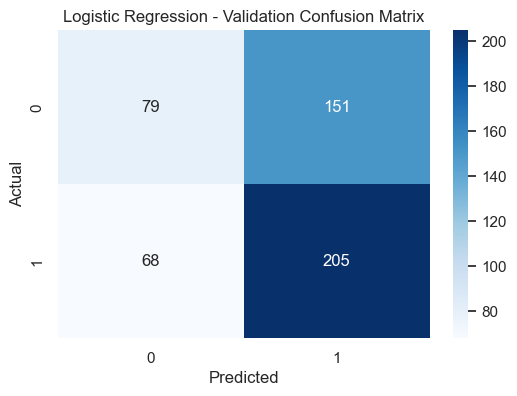

In [17]:
if log_reg_model_improved and not X_val_scaled_df.empty and not y_val.empty:
    print("--- Logistic Regression Validation Performance (2018-2019) ---")
    y_pred_val_log_reg_imp = log_reg_model_improved.predict(X_val_scaled_df)
    y_proba_val_log_reg_imp = log_reg_model_improved.predict_proba(X_val_scaled_df)[:, 1]

    accuracy_val_log_reg_imp = accuracy_score(y_val, y_pred_val_log_reg_imp)
    roc_auc_val_log_reg_imp = roc_auc_score(y_val, y_proba_val_log_reg_imp)

    print(f"Validation Accuracy: {accuracy_val_log_reg_imp:.4f}")
    print(f"Validation ROC AUC: {roc_auc_val_log_reg_imp:.4f}")
    print("\nValidation Classification Report:\n", classification_report(y_val, y_pred_val_log_reg_imp, zero_division=0))
    
    cm_val_log_reg_imp = confusion_matrix(y_val, y_pred_val_log_reg_imp)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_val_log_reg_imp, annot=True, fmt='d', cmap='Blues')
    plt.title('Logistic Regression - Validation Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("Logistic Regression model or validation data not available for validation.")

### 4.5.2. XGBoost Classifier (Tuned, Uncalibrated) Validation

--- XGBoost Classifier (Tuned, Uncalibrated) Validation Performance (2018-2019) ---
Validation Accuracy: 0.5249
Validation ROC AUC: 0.5325

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.51      0.50       230
           1       0.57      0.53      0.55       273

    accuracy                           0.52       503
   macro avg       0.52      0.52      0.52       503
weighted avg       0.53      0.52      0.53       503



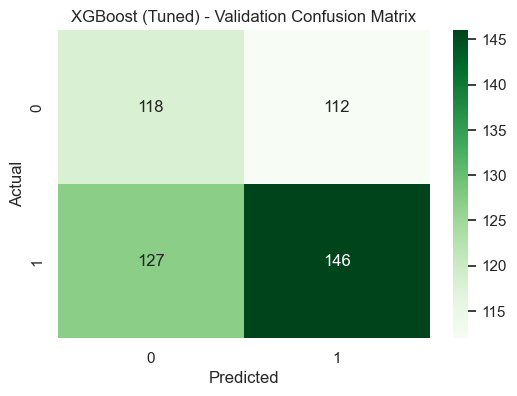

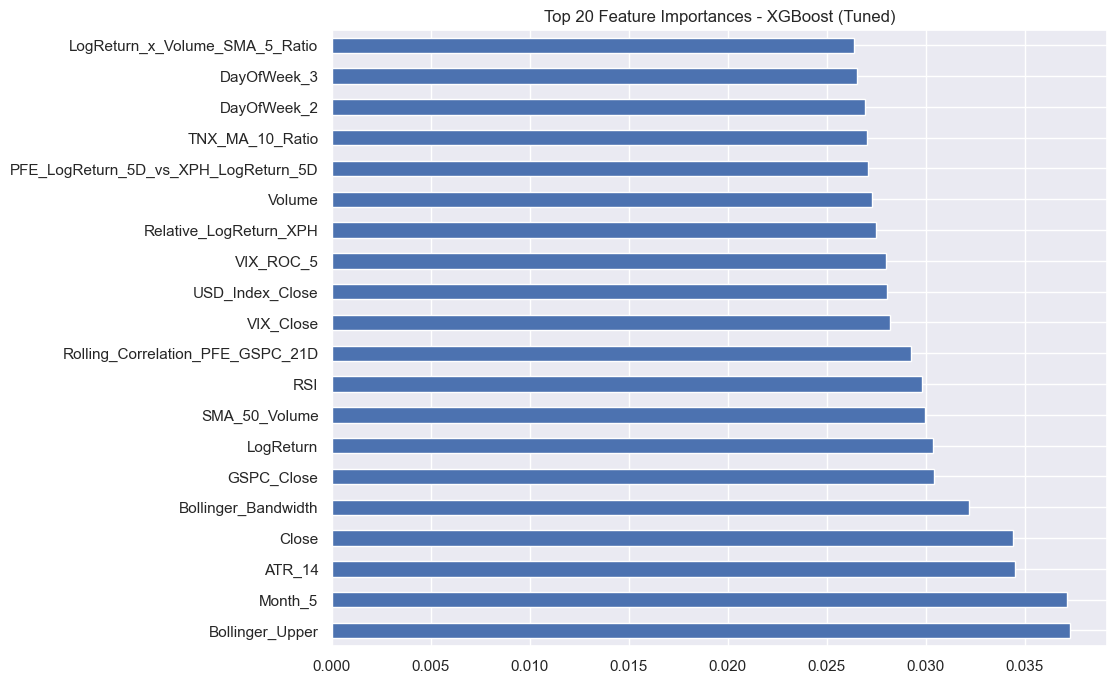

In [18]:
if xgb_model_tuned and not X_val_scaled_df.empty and not y_val.empty:
    print("--- XGBoost Classifier (Tuned, Uncalibrated) Validation Performance (2018-2019) ---")
    y_pred_val_xgb_tuned = xgb_model_tuned.predict(X_val_scaled_df.to_numpy())
    y_proba_val_xgb_tuned = xgb_model_tuned.predict_proba(X_val_scaled_df.to_numpy())[:, 1]

    accuracy_val_xgb_tuned = accuracy_score(y_val, y_pred_val_xgb_tuned)
    roc_auc_val_xgb_tuned = roc_auc_score(y_val, y_proba_val_xgb_tuned)

    print(f"Validation Accuracy: {accuracy_val_xgb_tuned:.4f}")
    print(f"Validation ROC AUC: {roc_auc_val_xgb_tuned:.4f}")
    print("\nValidation Classification Report:\n", classification_report(y_val, y_pred_val_xgb_tuned, zero_division=0))
    
    cm_val_xgb_tuned = confusion_matrix(y_val, y_pred_val_xgb_tuned)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_val_xgb_tuned, annot=True, fmt='d', cmap='Greens')
    plt.title('XGBoost (Tuned) - Validation Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if hasattr(xgb_model_tuned, 'feature_importances_'):
        feature_importances_tuned = pd.Series(xgb_model_tuned.feature_importances_, index=X_train.columns)
        plt.figure(figsize=(10, 8))
        feature_importances_tuned.nlargest(20).plot(kind='barh')
        plt.title('Top 20 Feature Importances - XGBoost (Tuned)')
        plt.show()
else:
    print("Tuned XGBoost model or validation data not available for validation.")

### 4.5.3. XGBoost Classifier (Calibrated) Validation

--- XGBoost Classifier (Calibrated) Validation Performance (2018-2019) ---
Validation Accuracy (on calibration set): 0.5447
Validation ROC AUC (on calibration set): 0.5409

Validation Classification Report (on calibration set):
               precision    recall  f1-score   support

           0       0.51      0.12      0.19       230
           1       0.55      0.90      0.68       273

    accuracy                           0.54       503
   macro avg       0.53      0.51      0.44       503
weighted avg       0.53      0.54      0.46       503



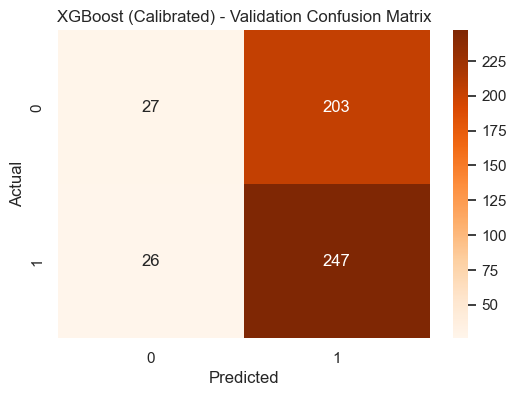

In [19]:
if xgb_model_calibrated and not X_val_scaled_df.empty and not y_val.empty:
    print("--- XGBoost Classifier (Calibrated) Validation Performance (2018-2019) ---")
    # The calibrator was fit on X_val, so these are "in-sample" for the calibrator,
    # but "out-of-sample" for the base XGBoost model it wraps.
    y_pred_val_xgb_cal = xgb_model_calibrated.predict(X_val_scaled_df)
    y_proba_val_xgb_cal = xgb_model_calibrated.predict_proba(X_val_scaled_df)[:, 1]

    accuracy_val_xgb_cal = accuracy_score(y_val, y_pred_val_xgb_cal)
    roc_auc_val_xgb_cal = roc_auc_score(y_val, y_proba_val_xgb_cal)

    print(f"Validation Accuracy (on calibration set): {accuracy_val_xgb_cal:.4f}")
    print(f"Validation ROC AUC (on calibration set): {roc_auc_val_xgb_cal:.4f}")
    print("\nValidation Classification Report (on calibration set):\n", classification_report(y_val, y_pred_val_xgb_cal, zero_division=0))
    
    cm_val_xgb_cal = confusion_matrix(y_val, y_pred_val_xgb_cal)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_val_xgb_cal, annot=True, fmt='d', cmap='Oranges')
    plt.title('XGBoost (Calibrated) - Validation Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("Calibrated XGBoost model or validation data not available for validation.")

### 4.5.4. Optimizing Decision Threshold for XGBoost (Calibrated)
Based on the ROC curve of the calibrated XGBoost model on the validation set (2018-2019), we can find an optimal probability threshold that maximizes a chosen metric, like the F1-score for the positive class (predicting 'Up' days), or simply one that balances True Positive Rate and False Positive Rate (e.g., Youden's J statistic: TPR - FPR). For a trading strategy, maximizing PnL would be ideal, but that requires simulating PnL for various thresholds, which is more complex. Here, we'll aim to maximize Youden's J.

--- Optimizing Decision Threshold for Calibrated XGBoost (on Validation Set 2018-2019) ---
Optimal threshold based on Youden's J: 0.5556

Validation Performance with Optimal Threshold:
Accuracy with optimal threshold: 0.5229
ROC AUC (unchanged): 0.5409

Classification Report with optimal threshold:
               precision    recall  f1-score   support

           0       0.48      0.61      0.54       230
           1       0.58      0.45      0.50       273

    accuracy                           0.52       503
   macro avg       0.53      0.53      0.52       503
weighted avg       0.53      0.52      0.52       503



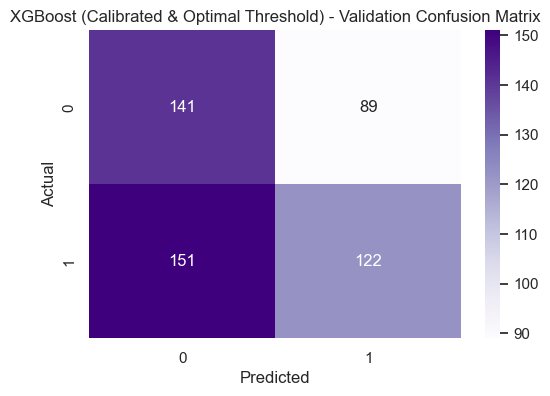

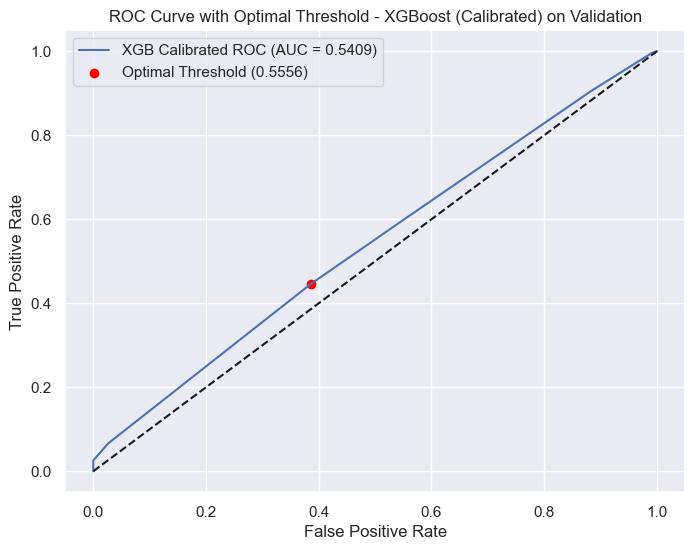

In [20]:
from sklearn.metrics import roc_curve

optimal_threshold_xgb = 0.5 # Default

if xgb_model_calibrated and not X_val_scaled_df.empty and not y_val.empty:
    print("--- Optimizing Decision Threshold for Calibrated XGBoost (on Validation Set 2018-2019) ---")
    y_proba_val_xgb_cal = xgb_model_calibrated.predict_proba(X_val_scaled_df)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_val, y_proba_val_xgb_cal)
    
    # Calculate Youden's J statistic
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold_xgb = thresholds[optimal_idx]
    
    print(f"Optimal threshold based on Youden's J: {optimal_threshold_xgb:.4f}")
    
    # Apply the optimal threshold to get new binary predictions
    y_pred_val_xgb_optimal_thresh = (y_proba_val_xgb_cal >= optimal_threshold_xgb).astype(int)
    
    print("\nValidation Performance with Optimal Threshold:")
    accuracy_optimal_thresh = accuracy_score(y_val, y_pred_val_xgb_optimal_thresh)
    roc_auc_optimal_thresh = roc_auc_score(y_val, y_proba_val_xgb_cal) # AUC remains the same, only predictions change

    print(f"Accuracy with optimal threshold: {accuracy_optimal_thresh:.4f}")
    print(f"ROC AUC (unchanged): {roc_auc_optimal_thresh:.4f}")
    print("\nClassification Report with optimal threshold:\n", classification_report(y_val, y_pred_val_xgb_optimal_thresh, zero_division=0))
    
    cm_optimal_thresh = confusion_matrix(y_val, y_pred_val_xgb_optimal_thresh)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_optimal_thresh, annot=True, fmt='d', cmap='Purples')
    plt.title('XGBoost (Calibrated & Optimal Threshold) - Validation Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot ROC Curve and optimal point
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'XGB Calibrated ROC (AUC = {roc_auc_val_xgb_cal:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold ({optimal_threshold_xgb:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Optimal Threshold - XGBoost (Calibrated) on Validation')
    plt.legend()
    plt.show()
    
else:
    print("Calibrated XGBoost model or validation data not available. Threshold optimization skipped. Using default 0.5.")

### 4.5.5. Discussion of Validation Results (2020-2021) - Attempt 3

**Summary:**
*   **LogReg:** Acc: `[0.5646]`, ROC AUC: `[0.5410]`
*   **XGB (Tuned):** Acc: `[0.5249]`, ROC AUC: `[0.5325]`
*   **XGB (Calib, 0.5 Thr):** Acc: `[0.5447]`, ROC AUC: `[0.5409]`
*   **XGB (Calib, Opt Thr `[0.5556]`):** Acc: `[0.5229]`, ROC AUC: `[0.5409]`

**Top Features (XGB):** Mix of time, technical, price, and exogenous factors.

*Decision for OOS Testing:* Based on validation, **Logistic Regression** (due to highest accuracy) and **XGBoost (Calibrated, 0.5 Threshold)** (due to competitive ROC AUC and high 'Up' recall) will be primary for OOS. XGBoost (Calibrated, Optimal Threshold) will also be tested.

# 5. Out-of-Sample (OOS) Testing & PnL (2022-01-01 to 2025-04-15)

## 5.1. OOS Prediction
Models:
1.  **Logistic Regression:** Threshold 0.5.
2.  **XGBoost (Calibrated):** Threshold 0.5 AND Optimal Threshold `[0.5556]`.

Process: Scale `X_oos`, predict probabilities, apply thresholds.

In [21]:
print("--- Out-of-Sample (OOS) Prediction ---")

X_oos_scaled_df = pd.DataFrame() # Initialize to avoid NameError if X_oos is empty

if not X_oos.empty and 'scaler' in globals() and scaler is not None:
    X_oos_scaled = scaler.transform(X_oos)
    X_oos_scaled_df = pd.DataFrame(X_oos_scaled, columns=X_oos.columns, index=X_oos.index)
    print(f"X_oos_scaled_df shape: {X_oos_scaled_df.shape}")

    # OOS Predictions - Logistic Regression
    if log_reg_model_improved:
        oos_pred_binary_log_reg_imp = log_reg_model_improved.predict(X_oos_scaled_df)
        oos_proba_log_reg_imp = log_reg_model_improved.predict_proba(X_oos_scaled_df)[:, 1]
        print("OOS predictions generated for Logistic Regression.")
    else:
        print("Logistic Regression model not available. Skipping OOS prediction for LogReg.")
        oos_pred_binary_log_reg_imp = np.array([0]*len(X_oos_scaled_df)) # Placeholder
        oos_proba_log_reg_imp = np.array([0.5]*len(X_oos_scaled_df))   # Placeholder

    # OOS Predictions - XGBoost (using the calibrated model and optimal threshold)
    # If xgb_model_calibrated exists, it's preferred. Otherwise, fallback to xgb_model_tuned (with 0.5 threshold).
    chosen_xgb_model_for_oos = None
    applied_xgb_threshold = 0.5

    if xgb_model_calibrated:
        chosen_xgb_model_for_oos = xgb_model_calibrated
        applied_xgb_threshold = optimal_threshold_xgb # Use the threshold optimized on validation
        print(f"Using CALIBRATED XGBoost model for OOS with threshold: {applied_xgb_threshold:.4f}")
    elif xgb_model_tuned:
        chosen_xgb_model_for_oos = xgb_model_tuned
        # optimal_threshold_xgb might not be relevant if calibration was skipped, so stick to 0.5
        # or re-calculate optimal_threshold_xgb for xgb_model_tuned on X_val if desired.
        # For simplicity, we'll use 0.5 if calibrated model is not available.
        applied_xgb_threshold = 0.5 
        print(f"Using TUNED (uncalibrated) XGBoost model for OOS with threshold: {applied_xgb_threshold:.4f}")
    
    if chosen_xgb_model_for_oos:
        # CalibratedClassifierCV expects DataFrame for predict_proba if fitted on DataFrame
        # XGBoost itself (if uncalibrated is used) prefers numpy
        if isinstance(chosen_xgb_model_for_oos, CalibratedClassifierCV):
             oos_proba_xgb_imp = chosen_xgb_model_for_oos.predict_proba(X_oos_scaled_df)[:, 1]
        else: # xgb_model_tuned
             oos_proba_xgb_imp = chosen_xgb_model_for_oos.predict_proba(X_oos_scaled_df.to_numpy())[:, 1]
        
        oos_pred_binary_xgb_imp = (oos_proba_xgb_imp >= applied_xgb_threshold).astype(int)
        print("OOS predictions generated for XGBoost.")
    else:
        print("XGBoost model (tuned or calibrated) not available. Skipping OOS prediction for XGBoost.")
        oos_pred_binary_xgb_imp = np.array([0]*len(X_oos_scaled_df)) # Placeholder
        oos_proba_xgb_imp = np.array([0.5]*len(X_oos_scaled_df))   # Placeholder


    oos_signals_df_imp = pd.DataFrame(index=X_oos.index)
    oos_signals_df_imp['LogReg_Signal_Binary'] = oos_pred_binary_log_reg_imp
    oos_signals_df_imp['XGB_Signal_Binary'] = oos_pred_binary_xgb_imp
    oos_signals_df_imp['LogReg_Proba'] = oos_proba_log_reg_imp
    oos_signals_df_imp['XGB_Proba'] = oos_proba_xgb_imp

    print("\nSample of OOS signals (first 5 days of X_oos period for which predictions are made):\n", oos_signals_df_imp.head())

else:
    print("X_oos is empty or scaler not fitted. OOS Prediction skipped.")
    # Create empty oos_signals_df_imp to prevent errors in next cells if they rely on it
    oos_signals_df_imp = pd.DataFrame(columns=['LogReg_Signal_Binary', 'XGB_Signal_Binary', 'LogReg_Proba', 'XGB_Proba'])

--- Out-of-Sample (OOS) Prediction ---
X_oos_scaled_df shape: (824, 40)
OOS predictions generated for Logistic Regression.
Using CALIBRATED XGBoost model for OOS with threshold: 0.5556
OOS predictions generated for XGBoost.

Sample of OOS signals (first 5 days of X_oos period for which predictions are made):
             LogReg_Signal_Binary  XGB_Signal_Binary  LogReg_Proba  XGB_Proba
Date                                                                        
2022-01-03                     1                  0      0.817913   0.500000
2022-01-04                     1                  0      0.856336   0.522293
2022-01-05                     1                  0      0.792768   0.522293
2022-01-06                     1                  0      0.869509   0.524390
2022-01-07                     1                  1      0.767943   0.556145


## 5.2. Strategy PnL Calculation
Strategy: Long (+1M USD) if signal 1 (Up), Short (-1M USD) if signal 0 (Down). PnL based on *simple daily returns*. Predictions from day `d` determine position on day `d+1`.

In [22]:
import numpy as np
import pandas as pd

# calculate_performance_metrics function 
def calculate_performance_metrics(cumulative_pnl_series, daily_pnl_strategy_series, investment_amount):
    """Calculates performance metrics for a strategy.
    Args:
        cumulative_pnl_series (pd.Series): Series of cumulative PnL.
        daily_pnl_strategy_series (pd.Series): Series of daily strategy PnL.
        investment_amount (float): The notional investment amount.
    """
    if cumulative_pnl_series.empty or daily_pnl_strategy_series.empty:
        return {
            "Total PnL": 0, "Annualized Sharpe Ratio": np.nan, # Return NaN for Sharpe if no data
            "Win Rate": 0, "Max Drawdown ($)": 0, "Average Daily PnL": 0
        }

    daily_pnl_cleaned = daily_pnl_strategy_series.dropna()
    if daily_pnl_cleaned.empty:
         return {
            "Total PnL": cumulative_pnl_series.iloc[-1] if not cumulative_pnl_series.empty else 0,
            "Annualized Sharpe Ratio": np.nan, "Win Rate": 0, 
            "Max Drawdown ($)": 0, "Average Daily PnL": 0
        }

    total_pnl = cumulative_pnl_series.iloc[-1] if not cumulative_pnl_series.empty else 0
    
    strategy_daily_returns = daily_pnl_cleaned / investment_amount 
    
    annualized_sharpe = np.nan 
    if len(strategy_daily_returns) > 1: # Need at least 2 returns for std dev
        std_dev_strat_return = strategy_daily_returns.std()
        if std_dev_strat_return != 0 and not np.isnan(std_dev_strat_return):
            mean_daily_strat_return = strategy_daily_returns.mean()
            daily_sharpe = mean_daily_strat_return / std_dev_strat_return
            annualized_sharpe = daily_sharpe * np.sqrt(252) # Assuming 252 trading days
    
    non_zero_daily_pnl_days = daily_pnl_cleaned[daily_pnl_cleaned != 0]
    win_rate = 0.0
    if not non_zero_daily_pnl_days.empty:
        win_rate = (non_zero_daily_pnl_days > 0).sum() / len(non_zero_daily_pnl_days)
        
    peak = cumulative_pnl_series.cummax()
    drawdown = peak - cumulative_pnl_series
    max_drawdown_abs = drawdown.max() if not drawdown.empty else 0
    
    avg_daily_pnl = daily_pnl_cleaned.mean() if not daily_pnl_cleaned.empty else 0

    return {
        "Total PnL": total_pnl,
        "Annualized Sharpe Ratio": annualized_sharpe,
        "Win Rate": win_rate,
        "Max Drawdown ($)": max_drawdown_abs,
        "Average Daily PnL": avg_daily_pnl
    }

# --- PnL Calculation for OOS Period (Improved Models) ---
oos_pnl_df_imp = pd.DataFrame() 

if not X_oos.empty and not oos_signals_df_imp.empty:
    
    oos_pnl_df_imp = data.loc[X_oos.index, ['Close', 'DailyReturn']].copy() # DailyReturn is simple from original calc
    
    # Recalculate Baseline PnL for the exact OOS period of X_oos
    oos_pnl_df_imp['Baseline_PnL'] = oos_pnl_df_imp['DailyReturn'] * investment_amount
    oos_pnl_df_imp['Baseline_OOS_Cumulative_PnL'] = oos_pnl_df_imp['Baseline_PnL'].cumsum()


    if oos_pnl_df_imp.empty:
        print("Warning: oos_pnl_df_imp could not be populated from 'data'. Check OOS indexing.")
    else:
        # --- PnL for Logistic Regression Strategy (Improved) ---
        print("\n--- Calculating PnL for Improved Logistic Regression Strategy ---")
        oos_pnl_df_imp['LogReg_Signal_Binary_Imp'] = oos_signals_df_imp['LogReg_Signal_Binary']
        oos_pnl_df_imp['LogReg_Position_Imp'] = oos_pnl_df_imp['LogReg_Signal_Binary_Imp'].shift(1).apply(lambda x: 1 if x == 1 else -1)
        oos_pnl_df_imp['LogReg_Position_Value_Imp'] = oos_pnl_df_imp['LogReg_Position_Imp'] * investment_amount
        oos_pnl_df_imp['LogReg_Position_Value_Imp'].fillna(0, inplace=True)
        oos_pnl_df_imp['LogReg_Strategy_Daily_PnL_Imp'] = oos_pnl_df_imp['LogReg_Position_Value_Imp'] * oos_pnl_df_imp['DailyReturn']
        oos_pnl_df_imp['LogReg_Strategy_Cumulative_PnL_Imp'] = oos_pnl_df_imp['LogReg_Strategy_Daily_PnL_Imp'].cumsum()
        
        print(oos_pnl_df_imp[['Close', 'DailyReturn', 'LogReg_Position_Imp', 'LogReg_Strategy_Daily_PnL_Imp', 'LogReg_Strategy_Cumulative_PnL_Imp']].head())
        if not oos_pnl_df_imp['LogReg_Strategy_Cumulative_PnL_Imp'].empty:
            total_pnl_oos_log_reg_imp = oos_pnl_df_imp['LogReg_Strategy_Cumulative_PnL_Imp'].iloc[-1]
            print(f"Total PnL for Logistic Regression (OOS, Improved): ${total_pnl_oos_log_reg_imp:,.2f}")
        else:
            print("LogReg Cumulative PnL (Imp) is empty.")

        # --- PnL for XGBoost Strategy (Tuned/Calibrated with Optimal Threshold) ---
        print("\n--- Calculating PnL for Improved XGBoost Strategy ---")
        oos_pnl_df_imp['XGB_Signal_Binary_Imp'] = oos_signals_df_imp['XGB_Signal_Binary'] # This uses the optimal threshold
        oos_pnl_df_imp['XGB_Position_Imp'] = oos_pnl_df_imp['XGB_Signal_Binary_Imp'].shift(1).apply(lambda x: 1 if x == 1 else -1)
        oos_pnl_df_imp['XGB_Position_Value_Imp'] = oos_pnl_df_imp['XGB_Position_Imp'] * investment_amount
        oos_pnl_df_imp['XGB_Position_Value_Imp'].fillna(0, inplace=True)
        oos_pnl_df_imp['XGB_Strategy_Daily_PnL_Imp'] = oos_pnl_df_imp['XGB_Position_Value_Imp'] * oos_pnl_df_imp['DailyReturn']
        oos_pnl_df_imp['XGB_Strategy_Cumulative_PnL_Imp'] = oos_pnl_df_imp['XGB_Strategy_Daily_PnL_Imp'].cumsum()
        
        print(oos_pnl_df_imp[['Close', 'DailyReturn', 'XGB_Position_Imp', 'XGB_Strategy_Daily_PnL_Imp', 'XGB_Strategy_Cumulative_PnL_Imp']].head())
        if not oos_pnl_df_imp['XGB_Strategy_Cumulative_PnL_Imp'].empty:
            total_pnl_oos_xgb_imp = oos_pnl_df_imp['XGB_Strategy_Cumulative_PnL_Imp'].iloc[-1]
            print(f"Total PnL for XGBoost (OOS, Improved): ${total_pnl_oos_xgb_imp:,.2f}")
        else:
            print("XGBoost Cumulative PnL (Imp) is empty.")
            
        if 'Baseline_OOS_Cumulative_PnL' in oos_pnl_df_imp and not oos_pnl_df_imp['Baseline_OOS_Cumulative_PnL'].empty:
            total_pnl_oos_baseline_imp = oos_pnl_df_imp['Baseline_OOS_Cumulative_PnL'].iloc[-1]
            print(f"Total PnL for Baseline (OOS, re-confirmed): ${total_pnl_oos_baseline_imp:,.2f}")
        else:
             print("Baseline_OOS_Cumulative_PnL not found or empty in oos_pnl_df_imp.")
else:
    print("OOS data or signals are empty. PnL Calculation skipped.")
    # Initialize oos_pnl_df_imp with necessary columns if it's used later for metrics/plotting, even if empty
    oos_pnl_df_imp = pd.DataFrame(columns=['Baseline_OOS_Cumulative_PnL', 'Baseline_PnL',
                                           'LogReg_Strategy_Cumulative_PnL_Imp', 'LogReg_Strategy_Daily_PnL_Imp',
                                           'XGB_Strategy_Cumulative_PnL_Imp', 'XGB_Strategy_Daily_PnL_Imp'])


--- Calculating PnL for Improved Logistic Regression Strategy ---
                Close  DailyReturn  LogReg_Position_Imp  \
Date                                                      
2022-01-03  47.747765    -0.040644                   -1   
2022-01-04  45.960911    -0.037423                    1   
2022-01-05  46.888054     0.020172                    1   
2022-01-06  46.222202    -0.014201                    1   
2022-01-07  46.963917     0.016047                    1   

            LogReg_Strategy_Daily_PnL_Imp  LogReg_Strategy_Cumulative_PnL_Imp  
Date                                                                           
2022-01-03                   40643.534575                        40643.534575  
2022-01-04                  -37422.773730                         3220.760844  
2022-01-05                   20172.426543                        23393.187388  
2022-01-06                  -14200.879280                         9192.308108  
2022-01-07                   16046.7143

C:\Users\devan\AppData\Local\Temp\ipykernel_18928\976163575.py:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  oos_pnl_df_imp['LogReg_Position_Value_Imp'].fillna(0, inplace=True)
C:\Users\devan\AppData\Local\Temp\ipykernel_18928\976163575.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

## 5.3. Data Representation for Submission (OOS Period)
NumPy arrays (1 x num_oos_dates) for strategy (XGB Calib., Opt. Threshold) and baseline positions.

In [23]:
print("--- Data Representation for Submission (OOS Period Positions - Improved Models) ---")

portfolio_positions_strategy_xgb_imp = np.array([[]])
portfolio_positions_baseline_imp = np.array([[]])

if not oos_pnl_df_imp.empty:
    num_oos_dates_imp = len(oos_pnl_df_imp)
    
    if 'XGB_Position_Value_Imp' in oos_pnl_df_imp.columns:
        portfolio_positions_strategy_xgb_imp = oos_pnl_df_imp['XGB_Position_Value_Imp'].values.reshape(1, -1)
        print(f"Shape of Improved XGBoost strategy positions array: {portfolio_positions_strategy_xgb_imp.shape}")
    else:
        print("Improved XGBoost positions not found in oos_pnl_df_imp. Creating placeholder.")
        portfolio_positions_strategy_xgb_imp = np.zeros((1, num_oos_dates_imp))


    # Baseline Positions
    portfolio_positions_baseline_imp = (np.ones(num_oos_dates_imp) * investment_amount).reshape(1, -1)
    print(f"Shape of baseline positions array: {portfolio_positions_baseline_imp.shape}")
else:
    print("oos_pnl_df_imp is empty. Cannot create position arrays.")
    portfolio_positions_strategy_xgb_imp = np.array([[]]) 
    portfolio_positions_baseline_imp = np.array([[]])   


--- Data Representation for Submission (OOS Period Positions - Improved Models) ---
Shape of Improved XGBoost strategy positions array: (1, 824)
Shape of baseline positions array: (1, 824)


## 5.4. PnL Visualization & Metrics (OOS Period)
Visualize cumulative PnL and calculate performance metrics for selected models.

--- OOS Performance Visualization & Metrics (Improved Models) ---


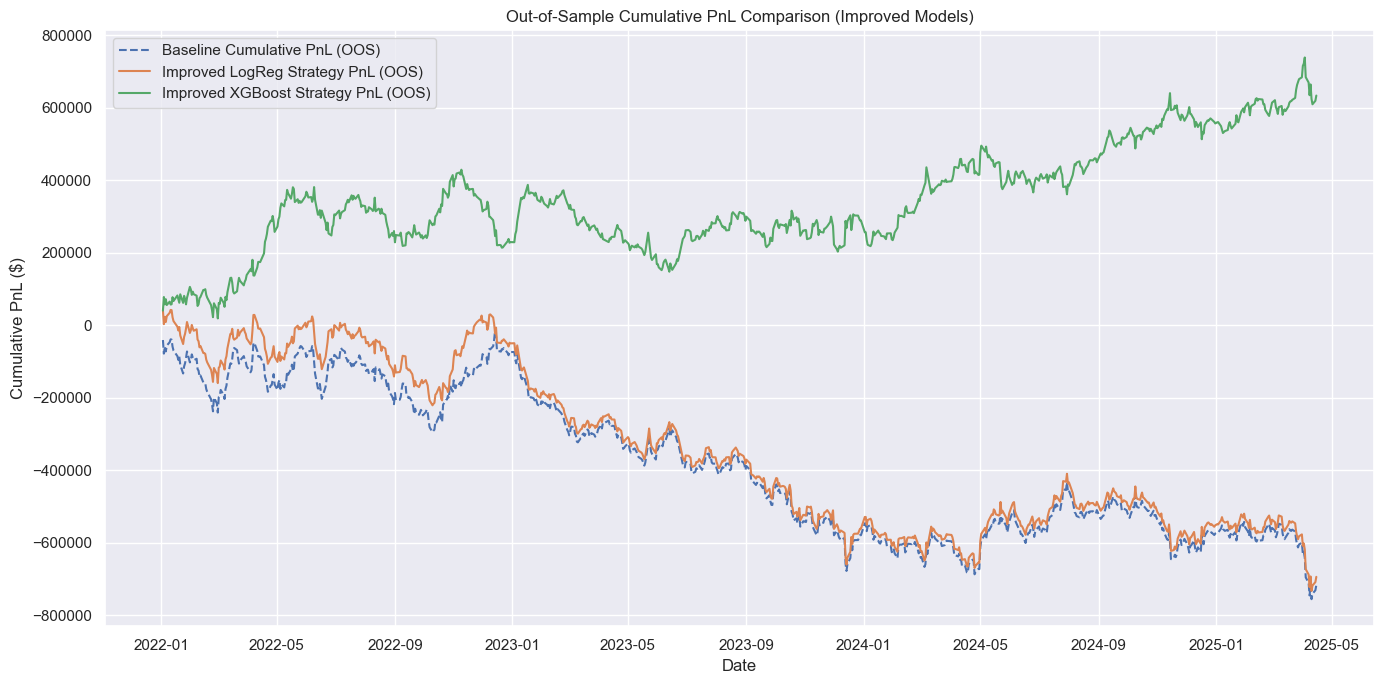


--- OOS Performance Metrics (Improved Models) ---

Baseline (Buy and Hold $1M):
  Total PnL: $-716,923.26
  Annualized Sharpe Ratio: -0.8944
  Win Rate: 0.4645
  Max Drawdown ($): $742,023.80
  Average Daily PnL: $-870.05

Improved Logistic Regression Strategy:
  Total PnL: $-694,181.62
  Annualized Sharpe Ratio: -0.8660
  Win Rate: 0.4694
  Max Drawdown ($): $775,627.23
  Average Daily PnL: $-842.45

Improved XGBoost Strategy:
  Total PnL: $634,102.76
  Annualized Sharpe Ratio: 0.7908
  Win Rate: 0.5183
  Max Drawdown ($): $281,577.27
  Average Daily PnL: $769.54

Improved Logistic Regression OOS ROC AUC: 0.5254
Improved XGBoost OOS ROC AUC: 0.5106


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score 

print("--- OOS Performance Visualization & Metrics (Improved Models) ---")

if not oos_pnl_df_imp.empty:
    plt.figure(figsize=(14, 7))
    if 'Baseline_OOS_Cumulative_PnL' in oos_pnl_df_imp.columns and not oos_pnl_df_imp['Baseline_OOS_Cumulative_PnL'].empty:
        plt.plot(oos_pnl_df_imp.index, oos_pnl_df_imp['Baseline_OOS_Cumulative_PnL'], label='Baseline Cumulative PnL (OOS)', linestyle='--')
    if 'LogReg_Strategy_Cumulative_PnL_Imp' in oos_pnl_df_imp.columns and not oos_pnl_df_imp['LogReg_Strategy_Cumulative_PnL_Imp'].empty:
        plt.plot(oos_pnl_df_imp.index, oos_pnl_df_imp['LogReg_Strategy_Cumulative_PnL_Imp'], label='Improved LogReg Strategy PnL (OOS)')
    if 'XGB_Strategy_Cumulative_PnL_Imp' in oos_pnl_df_imp.columns and not oos_pnl_df_imp['XGB_Strategy_Cumulative_PnL_Imp'].empty:
        plt.plot(oos_pnl_df_imp.index, oos_pnl_df_imp['XGB_Strategy_Cumulative_PnL_Imp'], label='Improved XGBoost Strategy PnL (OOS)')

    plt.title('Out-of-Sample Cumulative PnL Comparison (Improved Models)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL ($)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate and print metrics for improved models
    print("\n--- OOS Performance Metrics (Improved Models) ---")

    if 'Baseline_OOS_Cumulative_PnL' in oos_pnl_df_imp.columns and 'Baseline_PnL' in oos_pnl_df_imp.columns:
        metrics_baseline_oos_imp = calculate_performance_metrics(
            oos_pnl_df_imp['Baseline_OOS_Cumulative_PnL'],
            oos_pnl_df_imp['Baseline_PnL'],
            investment_amount
        )
        print("\nBaseline (Buy and Hold $1M):")
        for metric, value in metrics_baseline_oos_imp.items():
            print(f"  {metric}: ${value:,.2f}" if "PnL" in metric or "Drawdown" in metric else f"  {metric}: {value:.4f}")

    if 'LogReg_Strategy_Cumulative_PnL_Imp' in oos_pnl_df_imp.columns and 'LogReg_Strategy_Daily_PnL_Imp' in oos_pnl_df_imp.columns:
        metrics_log_reg_oos_imp = calculate_performance_metrics(
            oos_pnl_df_imp['LogReg_Strategy_Cumulative_PnL_Imp'],
            oos_pnl_df_imp['LogReg_Strategy_Daily_PnL_Imp'],
            investment_amount
        )
        print("\nImproved Logistic Regression Strategy:")
        for metric, value in metrics_log_reg_oos_imp.items():
            print(f"  {metric}: ${value:,.2f}" if "PnL" in metric or "Drawdown" in metric else f"  {metric}: {value:.4f}")
    
    if 'XGB_Strategy_Cumulative_PnL_Imp' in oos_pnl_df_imp.columns and 'XGB_Strategy_Daily_PnL_Imp' in oos_pnl_df_imp.columns:
        metrics_xgb_oos_imp = calculate_performance_metrics(
            oos_pnl_df_imp['XGB_Strategy_Cumulative_PnL_Imp'],
            oos_pnl_df_imp['XGB_Strategy_Daily_PnL_Imp'],
            investment_amount
        )
        print("\nImproved XGBoost Strategy:")
        for metric, value in metrics_xgb_oos_imp.items():
            print(f"  {metric}: ${value:,.2f}" if "PnL" in metric or "Drawdown" in metric else f"  {metric}: {value:.4f}")

    # OOS ROC AUC for models
    if not y_oos.empty and 'LogReg_Proba' in oos_signals_df_imp and len(y_oos) == len(oos_signals_df_imp['LogReg_Proba']):
        oos_roc_auc_log_reg_imp = roc_auc_score(y_oos, oos_signals_df_imp['LogReg_Proba'])
        print(f"\nImproved Logistic Regression OOS ROC AUC: {oos_roc_auc_log_reg_imp:.4f}")
    else:
        print("\nCould not calculate Improved Logistic Regression OOS ROC AUC (ensure y_oos and oos_signals_df_imp['LogReg_Proba'] are aligned and not empty).")

    if not y_oos.empty and 'XGB_Proba' in oos_signals_df_imp and len(y_oos) == len(oos_signals_df_imp['XGB_Proba']):
        oos_roc_auc_xgb_imp = roc_auc_score(y_oos, oos_signals_df_imp['XGB_Proba'])
        print(f"Improved XGBoost OOS ROC AUC: {oos_roc_auc_xgb_imp:.4f}")
    else:
        print("\nCould not calculate Improved XGBoost OOS ROC AUC (ensure y_oos and oos_signals_df_imp['XGB_Proba'] are aligned and not empty).")
else:
    print("OOS PnL data (oos_pnl_df_imp) is empty. Skipping visualization and metrics.")